# Data Scraping

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

"""
During the scraping we found out that the class selector are changing in kijiji so we defined 
as constant at the top of the application. if we have to re scrape and class has changed we can just change the 
class selector below
"""
CONDITION_AND_DISTANCE_CLASS_SELECTOR = "sc-dAbbOL bhyuIE sc-eBHhsj jqgoLC"
OTHER_INFO_CLASS_SELECTOR = "sc-kMribo rPfKd"
PRICE_SELECTOR_CLASS = "sc-57d74591-0 bKIIQc"
SINGLE_CAR_OUTER_DIV_SELECTOR = "sc-2e07e5ea-4 fNqxMz"
TITLE_SELECTOR_CLASS = "sc-2e07e5ea-0 gpxjNR"

base_url = "https://www.kijiji.ca"
url = "https://www.kijiji.ca/b-ontario/car/k0l9004?dc=true"
page_url = "https://www.kijiji.ca/b-ontario/car/page-2/k0l9004?dc=true"

# defining dataset columns that are to be scraped
dataset_column = ['Price',
                  'Title',
                  'Condition',
                  'Kilometers',
                  'Year:',
                  'Drivetrain:',
                  'Make:',
                  'Transmission:',
                  'Model:',
                  'Fuel Type:',
                  'Colour:',
                  'Body Type:'
                  ]

# for details info (separating this according to class selector in kijiji website)
details_info_columns = ['Condition',
                        'Kilometers',
                        'Year:',
                        'Drivetrain:',
                        'Make:',
                        'Transmission:',
                        'Model:',
                        'Fuel Type:',
                        'Colour:',
                        'Body Type:'
                        ]

# defining default values for column if data is not present at website
default_col_dictionary = {
    'Condition': "",
    'Kilometers': "0",
    'Year:': "0",
    'Drivetrain:': "",
    'Make:': "",
    'Transmission:': "",
    'Model:': "",
    'Fuel Type:': "",
    'Colour:': "",
    'Body Type:': ""
}


# method to extract no of pages
def get_last_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    pages = soup.findAll("li", {"data-testid": "pagination-list-item"})
    return int((pages[-1].find("a").text).replace("Go to page ", ""))


# method to extract details info of each car
def get_info_details_list(details, info):
    for item in info:
        spans = item.findAll("span")
        if len(spans) == 2:
            label = spans[0].text.strip()
            details[label] = spans[1].text


# main method to get each car details row
def get_car_details(href, page, car_number):
    try:
        # condition, km,year,make,model,trim,color,body_type,drivetrain,transmission,fuel_type,vin,stock,description
        details = {}
        response = requests.get(f"{base_url}{href}")
        soup = BeautifulSoup(response.text, 'html.parser')
        condition_and_distance = soup.findAll("div", {"class": CONDITION_AND_DISTANCE_CLASS_SELECTOR})
        get_info_details_list(details, condition_and_distance)

        other_info = soup.findAll("li", {"class": OTHER_INFO_CLASS_SELECTOR})
        get_info_details_list(details, other_info)

        details_list = []
        for item in details_info_columns:
            details_list.append(details.get(item, default_col_dictionary.get(item)))
        return details_list
    except:
        print(f"Exception occurs while getting details information page:{page} and car number: {car_number}")


# method to write data to csv
def write_to_csv(item_list):
    df = pd.DataFrame([item_list])
    df.to_csv('output.csv', mode='a', index=False, header=False)


# extracting price, title and calling info details method to get other info
def get_car_info(url, page):
    try:
        response = requests.get(url)

        # print(response.text)

        soup = BeautifulSoup(response.text, 'html.parser')

        car_div = soup.findAll("div", {"class": SINGLE_CAR_OUTER_DIV_SELECTOR})
        # print(len(car_div))
        count = 0;
        for div in car_div:
            count += 1
            price = div.find("div", {"class": PRICE_SELECTOR_CLASS})
            title = div.find("a", {"class": TITLE_SELECTOR_CLASS})
            # print(title['href'])
            individual_div = []
            if hasattr(price, "text"):
                individual_div.append(price.text)
            else:
                individual_div.append("0")

            if hasattr(title, "text"):
                individual_div.append(title.text)
            else:
                individual_div.append("")
            individual_div += get_car_details(title["href"], page, count)
            write_to_csv(individual_div)
            print(f"\t\tCar {count} is done!!!")
    except:
        print(f"Exception occurs while reading the page {page}")


# main method to getting started
def main():
    write_to_csv(dataset_column)
    total_page = get_last_page(page_url)
    print(f"Total page:{total_page}")
    for page in range(1, total_page + 1):
        new_url = f"https://www.kijiji.ca/b-ontario/car/page-{page}/k0l9004?dc=true"
        print(f"Page {page} is processing ⏱️⏱️⏱️")
        get_car_info(new_url, page)
        print(f"Page {page + 1} is Done 🆗🆗🆗")


# calling main method
main()



# Starting with reading the Data

In [2]:
#Importing necessary library to readand visualize data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#reading the csv file
df= pd.read_csv('output.csv', encoding='cp1252')

In [4]:
#Looking at the data
df.head()

,Price,Title,Condition,Kilometers,Year:,Drivetrain:,Make:,Transmission:,Model:,Fuel Type:,Colour:,Body Type:
0,"$18,990.00",2019 Dodge Journey SE AUT0 A/C TOW PKG BLUETO...,Used,"154,208",2019,Front-wheel drive (FWD),Dodge,Automatic,Journey,Gasoline,Black,"SUV, Crossover"
1,"$24,590.00","2019 Honda Civic Sedan EX w/ Moonroof, Apple C...",Used,"67,049",2019,Front-wheel drive (FWD),Honda,Automatic,Civic,Other,Black,Sedan
2,"$6,500.00",2008 Acura TL,Used,"290,000",2008,NaN,Acura,Automatic,TL,Gasoline,Black,Sedan
3,0,2020 Volkswagen Tiguan,Used,"111,642",2020,All-wheel drive (AWD),Volkswagen,Automatic,Tiguan,Gasoline,Other,"SUV, Crossover"
4,"$43,990.00",2020 Chevrolet Express Cargo Van 2500 155 |LEA...,Used,"96,506",2020,Rear-wheel drive (RWD),Chevrolet,Automatic,Express,Gasoline,White,"Minivan, Van"


In [5]:
# Looking at the information of the data and its datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23586 entries, 0 to 23585
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Price          23586 non-null  object
 1   Title          23586 non-null  object
 2   Condition      23569 non-null  object
 3   Kilometers     23586 non-null  object
 4   Year:          23586 non-null  int64 
 5   Drivetrain:    21995 non-null  object
 6   Make:          23569 non-null  object
 7   Transmission:  21133 non-null  object
 8   Model:         23549 non-null  object
 9   Fuel Type:     22364 non-null  object
 10  Colour:        22331 non-null  object
 11  Body Type:     23569 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.2+ MB


In [6]:
#Looking at the columns in the dataset
df.columns

Index(['Price', 'Title', 'Condition', 'Kilometers', 'Year:', 'Drivetrain:',
       'Make:', 'Transmission:', 'Model:', 'Fuel Type:', 'Colour:',
       'Body Type:'],
      dtype='object')

# Data Wrangling

In [7]:
#removing the unnecessary characters in price and converting it to number.
import re
def convert_to_number(string):
    match = re.search(r'\d[\d,]+', str(string))
    if match:
        return float(match.group().replace(',', ''))
    else:
        return np.nan

# calling the conversion function
df['Price'] = df['Price'].apply(convert_to_number)


In [8]:
#removing ',' from kilometers and converting it to integer
df['Kilometers'] = df['Kilometers'].replace(',', '', regex=True).astype(int)

In [9]:
df.head()

,Price,Title,Condition,Kilometers,Year:,Drivetrain:,Make:,Transmission:,Model:,Fuel Type:,Colour:,Body Type:
0,18990.0,2019 Dodge Journey SE AUT0 A/C TOW PKG BLUETO...,Used,154208,2019,Front-wheel drive (FWD),Dodge,Automatic,Journey,Gasoline,Black,"SUV, Crossover"
1,24590.0,"2019 Honda Civic Sedan EX w/ Moonroof, Apple C...",Used,67049,2019,Front-wheel drive (FWD),Honda,Automatic,Civic,Other,Black,Sedan
2,6500.0,2008 Acura TL,Used,290000,2008,NaN,Acura,Automatic,TL,Gasoline,Black,Sedan
3,NaN,2020 Volkswagen Tiguan,Used,111642,2020,All-wheel drive (AWD),Volkswagen,Automatic,Tiguan,Gasoline,Other,"SUV, Crossover"
4,43990.0,2020 Chevrolet Express Cargo Van 2500 155 |LEA...,Used,96506,2020,Rear-wheel drive (RWD),Chevrolet,Automatic,Express,Gasoline,White,"Minivan, Van"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23586 entries, 0 to 23585
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          21163 non-null  float64
 1   Title          23586 non-null  object 
 2   Condition      23569 non-null  object 
 3   Kilometers     23586 non-null  int32  
 4   Year:          23586 non-null  int64  
 5   Drivetrain:    21995 non-null  object 
 6   Make:          23569 non-null  object 
 7   Transmission:  21133 non-null  object 
 8   Model:         23549 non-null  object 
 9   Fuel Type:     22364 non-null  object 
 10  Colour:        22331 non-null  object 
 11  Body Type:     23569 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(9)
memory usage: 2.1+ MB


- The Column Kilometer and Year have been converted to integer and price to float.

In [11]:
#Converting year to date time
df['Year:'] = pd.to_datetime(df['Year:'], format='%Y',errors='coerce')

In [12]:
#Filling na values with mean in the column year
average_date = df['Year:'].mean()

# Filling all the dates with the average date
df['Year:'].fillna(average_date, inplace=True)

In [13]:
df['Year:'] = pd.to_datetime(df['Year:'].dt.year.astype(str))

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23586 entries, 0 to 23585
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Price          21163 non-null  float64       
 1   Title          23586 non-null  object        
 2   Condition      23569 non-null  object        
 3   Kilometers     23586 non-null  int32         
 4   Year:          23586 non-null  datetime64[ns]
 5   Drivetrain:    21995 non-null  object        
 6   Make:          23569 non-null  object        
 7   Transmission:  21133 non-null  object        
 8   Model:         23549 non-null  object        
 9   Fuel Type:     22364 non-null  object        
 10  Colour:        22331 non-null  object        
 11  Body Type:     23569 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 2.1+ MB


- Date has been converted to datetime format

In [15]:
df.head()

,Price,Title,Condition,Kilometers,Year:,Drivetrain:,Make:,Transmission:,Model:,Fuel Type:,Colour:,Body Type:
0,18990.0,2019 Dodge Journey SE AUT0 A/C TOW PKG BLUETO...,Used,154208,2019-01-01,Front-wheel drive (FWD),Dodge,Automatic,Journey,Gasoline,Black,"SUV, Crossover"
1,24590.0,"2019 Honda Civic Sedan EX w/ Moonroof, Apple C...",Used,67049,2019-01-01,Front-wheel drive (FWD),Honda,Automatic,Civic,Other,Black,Sedan
2,6500.0,2008 Acura TL,Used,290000,2008-01-01,NaN,Acura,Automatic,TL,Gasoline,Black,Sedan
3,NaN,2020 Volkswagen Tiguan,Used,111642,2020-01-01,All-wheel drive (AWD),Volkswagen,Automatic,Tiguan,Gasoline,Other,"SUV, Crossover"
4,43990.0,2020 Chevrolet Express Cargo Van 2500 155 |LEA...,Used,96506,2020-01-01,Rear-wheel drive (RWD),Chevrolet,Automatic,Express,Gasoline,White,"Minivan, Van"


In [16]:
df['Year:'] = df['Year:'].dt.year

# Handling Missing Values

In [17]:
#Looking at the transpose of the data
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Price,18990.0,24590.0,6500.0,NaN,43990.0,NaN,24999.0,21995.0,48933.0,30990.0
Title,2019 Dodge Journey SE AUT0 A/C TOW PKG BLUETO...,"2019 Honda Civic Sedan EX w/ Moonroof, Apple C...",2008 Acura TL,2020 Volkswagen Tiguan,2020 Chevrolet Express Cargo Van 2500 155 |LEA...,2020 Kia Sportage EX,2014 Ford F-150 XLT Reg Cab 8ft Long Box 4X4 ...,2016 Honda Civic EX Sunroof | Back up Camera |...,2019 Ram 3500 BIG HORN 4X4 8' BOX | BACKUP CA...,2020 Nissan Rogue SV AWD w/PwrSeat/HtdSeats/R...
Condition,Used,Used,Used,Used,Used,Used,Used,Used,Used,Used
Kilometers,154208,67049,290000,111642,96506,75227,91421,105000,49829,52471
Year:,2019,2019,2008,2020,2020,2020,2014,2016,2019,2020
Drivetrain:,Front-wheel drive (FWD),Front-wheel drive (FWD),NaN,All-wheel drive (AWD),Rear-wheel drive (RWD),All-wheel drive (AWD),4 x 4,Front-wheel drive (FWD),4 x 4,All-wheel drive (AWD)
Make:,Dodge,Honda,Acura,Volkswagen,Chevrolet,Kia,Ford,Honda,Ram,Nissan
Transmission:,Automatic,Automatic,Automatic,Automatic,Automatic,Automatic,Automatic,Automatic,Automatic,Automatic
Model:,Journey,Civic,TL,Tiguan,Express,Sportage,F-150,Civic,3500,Rogue
Fuel Type:,Gasoline,Other,Gasoline,Gasoline,Gasoline,Gasoline,Gasoline,Gasoline,Gasoline,Gasoline


In [18]:
# Sorting DataFrame in date order
df.sort_values(by=["Year:"], inplace=True, ascending=True)

In [19]:
# removing kilometers with value 0 and 1.
df = df[~df['Kilometers'].isin([0, 1])]

In [20]:
df.head()

,Price,Title,Condition,Kilometers,Year:,Drivetrain:,Make:,Transmission:,Model:,Fuel Type:,Colour:,Body Type:
3430,6900.0,1941 Buick Eight,Used,50000,1941,Other,Buick,NaN,Other,Hybrid-Electric,Black,Other
17184,90000.0,"1966 Mercedes-Benz 230 SL ""Pagoda"" Stunning v...",Used,122000,1966,Rear-wheel drive (RWD),Mercedes-Benz,Automatic,SL-Class,Gasoline,Black,Convertible
21401,24995.0,1968 Ford F-250 *MERCURY M250*GREAT CONDITION...,Used,70585,1968,Rear-wheel drive (RWD),Ford,Automatic,F-250,Gasoline,Blue,Pickup Truck
14666,69900.0,1969 BLACK CHEVROLET SS CHEVELLE FOUR GEAR 396,Used,17545,1969,NaN,Chevrolet,Automatic,Chevelle,NaN,Black,Coupe (2 door)
14644,69900.0,1969 BLACK CHEVROLET SS CHEVELLE FOUR GEAR 396,Used,17545,1969,NaN,Chevrolet,Automatic,Chevelle,NaN,Black,Coupe (2 door)


In [21]:
#Looking for the different types of fuel.
unique_values_column= df['Fuel Type:'].unique()
unique_values_column

array(['Hybrid-Electric', 'Gasoline', nan, 'Other', 'Diesel', 'Electric'],
      dtype=object)

In [22]:
#Looking for the types of car on the basis of Transmission
unique_values_column= df['Transmission:'].unique()
unique_values_column

array([nan, 'Automatic', 'Manual', 'Other', '0'], dtype=object)

In [23]:
#Looking for the types of car on the basis of Drivetrain
unique_values_column= df['Drivetrain:'].unique()
unique_values_column

array(['Other', 'Rear-wheel drive (RWD)', nan, 'Front-wheel drive (FWD)',
       '4 x 4', 'All-wheel drive (AWD)'], dtype=object)

In [24]:
# Replacing 0 with nan in the dataframe
df.replace('0', np.nan, inplace=True)

In [25]:
#Looking for null values
df.isna().sum()

Price            2119
Title               0
Condition           0
Kilometers          0
Year:               0
Drivetrain:      1564
Make:               0
Transmission:    2220
Model:             20
Fuel Type:       1196
Colour:          1228
Body Type:          0
dtype: int64

In [26]:
#Imputting null values in price with mean
fill_values = {'Price': df['Price'].mean()}
df = df.fillna(value=fill_values)

In [27]:
#Drpoing the na vaues
df = df.dropna()

In [28]:
#looking for null values
df.isna().sum()

Price            0
Title            0
Condition        0
Kilometers       0
Year:            0
Drivetrain:      0
Make:            0
Transmission:    0
Model:           0
Fuel Type:       0
Colour:          0
Body Type:       0
dtype: int64

- The na values has been removed after dropping the na values.

# Plotting columns

C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\1394666494.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.scatter(df["Year:"][:1000], df["Price"][:1000])


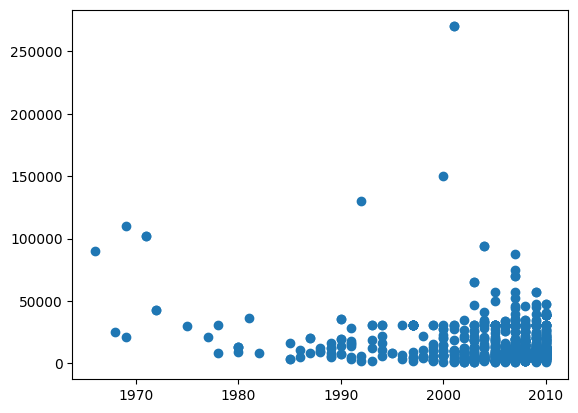

In [29]:
#Plotting scarplor with column year and price
fig, ax = plt.subplots()
ax.scatter(df["Year:"][:1000], df["Price"][:1000])

- From the above Scatter plot we can see that the newer model cars are priced much higher that older model cars.

<AxesSubplot: ylabel='Frequency'>

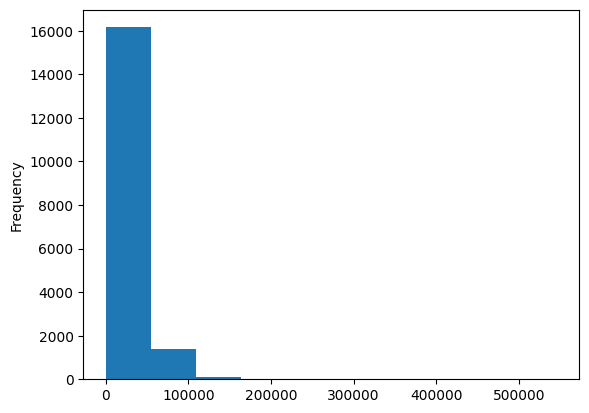

In [30]:
#Plotting histogram of column Price
df.Price.plot.hist()

- The above histogram shows that most of the cars are priced below 50,000.
- There are very little cars that are priced above 100,000.

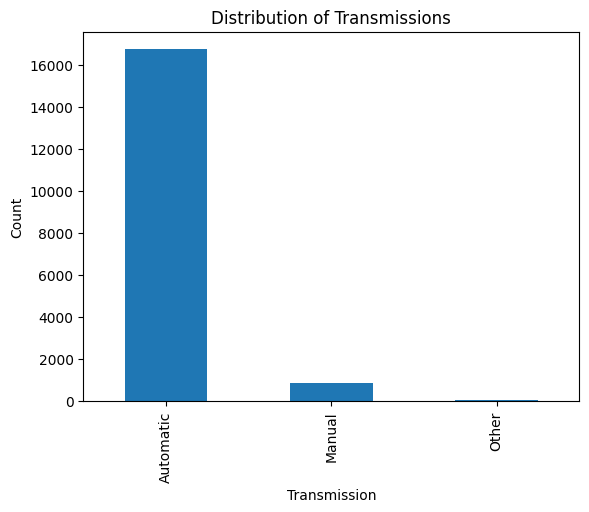

In [31]:
df['Transmission:'].value_counts().plot(kind='bar')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.title('Distribution of Transmissions')
plt.show()

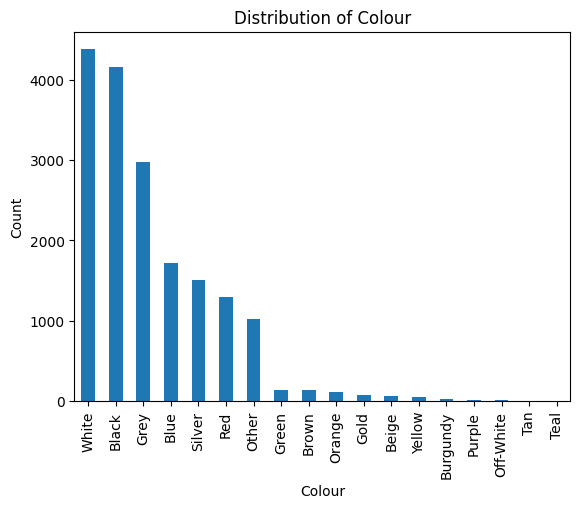

In [32]:
df['Colour:'].value_counts().plot(kind='bar')
plt.xlabel('Colour')
plt.ylabel('Count')
plt.title('Distribution of Colour')
plt.show()

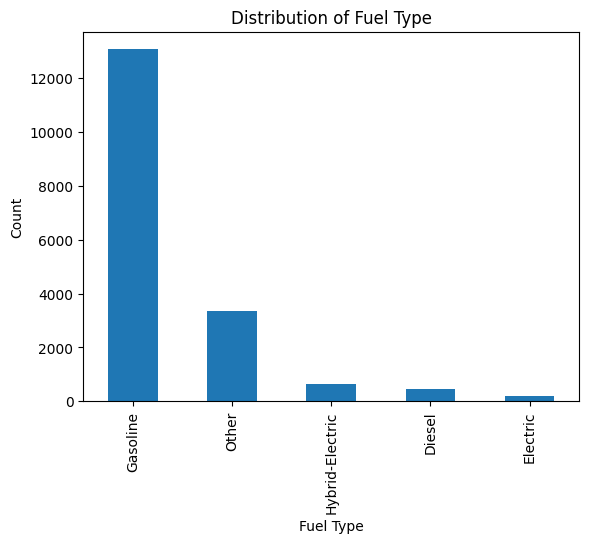

In [33]:
df['Fuel Type:'].value_counts().plot(kind='bar')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.title('Distribution of Fuel Type')
plt.show()

In [34]:
# looking at the description of numerical columns
df.describe()

,Price,Kilometers,Year:
count,17696.000000,1.769600e+04,17696.000000
mean,32086.604754,9.667409e+04,2017.747401
std,22579.474345,8.654052e+04,4.545565
min,33.000000,2.000000e+00,1966.000000
25%,20950.000000,4.470925e+04,2016.000000
50%,30829.115343,8.135950e+04,2019.000000
75%,37891.000000,1.330510e+05,2021.000000
max,545888.000000,3.893027e+06,2024.000000


In [35]:
#Final length of dataframe 
len(df)

17696

# Pandas profiling

In [36]:
from pandas_profiling import ProfileReport
# Generate the Pandas Profiling report
profile = ProfileReport(df)
profile.to_file("pandas_profiling_report.html")

C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\4191152894.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\pandas_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Encoding

In [37]:
#One hot encoding categorical columns i.e. Fuel Type, Transmission, Drivetrain and Condition
from sklearn.base import BaseEstimator, TransformerMixin
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        categorical_columns = ['Fuel Type:','Transmission:', 'Drivetrain:','Condition']
        X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
        return X_encoded
category_enc = CategoricalEncoder()
df = category_enc.transform(df)
df.head()

,Price,Title,Kilometers,Year:,Make:,Model:,Colour:,Body Type:,Fuel Type:_Electric,Fuel Type:_Gasoline,...,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used
17184,90000.0,"1966 Mercedes-Benz 230 SL ""Pagoda"" Stunning v...",122000,1966,Mercedes-Benz,SL-Class,Black,Convertible,0,1,...,0,0,0,0,0,0,1,0,0,1
21401,24995.0,1968 Ford F-250 *MERCURY M250*GREAT CONDITION...,70585,1968,Ford,F-250,Blue,Pickup Truck,0,1,...,0,0,0,0,0,0,1,0,0,1
12496,109800.0,"1969 Chevrolet Camaro Z/28 302 4-SPEED, NUMBER...",138190,1969,Chevrolet,Camaro,Orange,Other,0,0,...,1,1,0,0,0,0,1,0,0,1
17787,21000.0,"1969 Volkswagen Beetle "" Extremely Rare Automa...",84468,1969,Volkswagen,Beetle,Beige,Coupe (2 door),0,1,...,0,0,0,0,0,0,1,0,0,1
5568,102000.0,1971 Plymouth GTX RWD | POWER WINDOWS | SATEL...,42700,1971,Plymouth,GTX,Blue,Coupe (2 door),0,1,...,0,0,0,0,1,0,0,0,0,1


- The categorical columns like Fuel Type, Transmission, Drivetrain and Condition were one hot encoded.

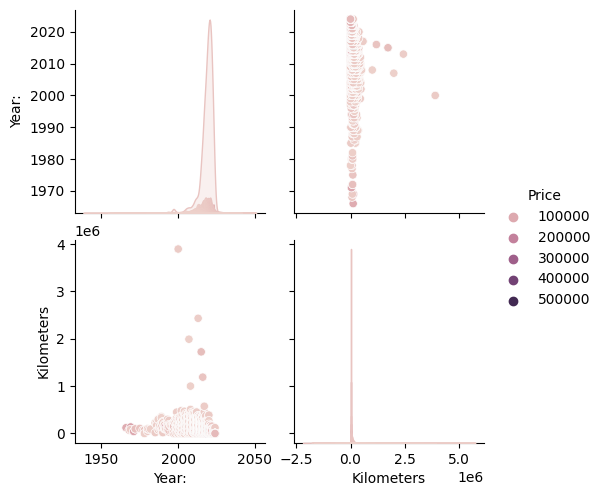

In [38]:
#Plotting Price year and Kilometers after encoding
import seaborn as sns
new_df = df[['Price','Year:','Kilometers']]
sns.pairplot(new_df, hue ='Price')
plt.show()

array([[<AxesSubplot: title={'center': 'Price'}>,
        <AxesSubplot: title={'center': 'Kilometers'}>,
        <AxesSubplot: title={'center': 'Year:'}>,
        <AxesSubplot: title={'center': 'Fuel Type:_Electric'}>],
       [<AxesSubplot: title={'center': 'Fuel Type:_Gasoline'}>,
        <AxesSubplot: title={'center': 'Fuel Type:_Hybrid-Electric'}>,
        <AxesSubplot: title={'center': 'Fuel Type:_Other'}>,
        <AxesSubplot: title={'center': 'Transmission:_Manual'}>],
       [<AxesSubplot: title={'center': 'Transmission:_Other'}>,
        <AxesSubplot: title={'center': 'Drivetrain:_All-wheel drive (AWD)'}>,
        <AxesSubplot: title={'center': 'Drivetrain:_Front-wheel drive (FWD)'}>,
        <AxesSubplot: title={'center': 'Drivetrain:_Other'}>],
       [<AxesSubplot: title={'center': 'Drivetrain:_Rear-wheel drive (RWD)'}>,
        <AxesSubplot: title={'center': 'Condition_Lease Takeover'}>,
        <AxesSubplot: title={'center': 'Condition_Salvage'}>,
        <AxesSubplot: t

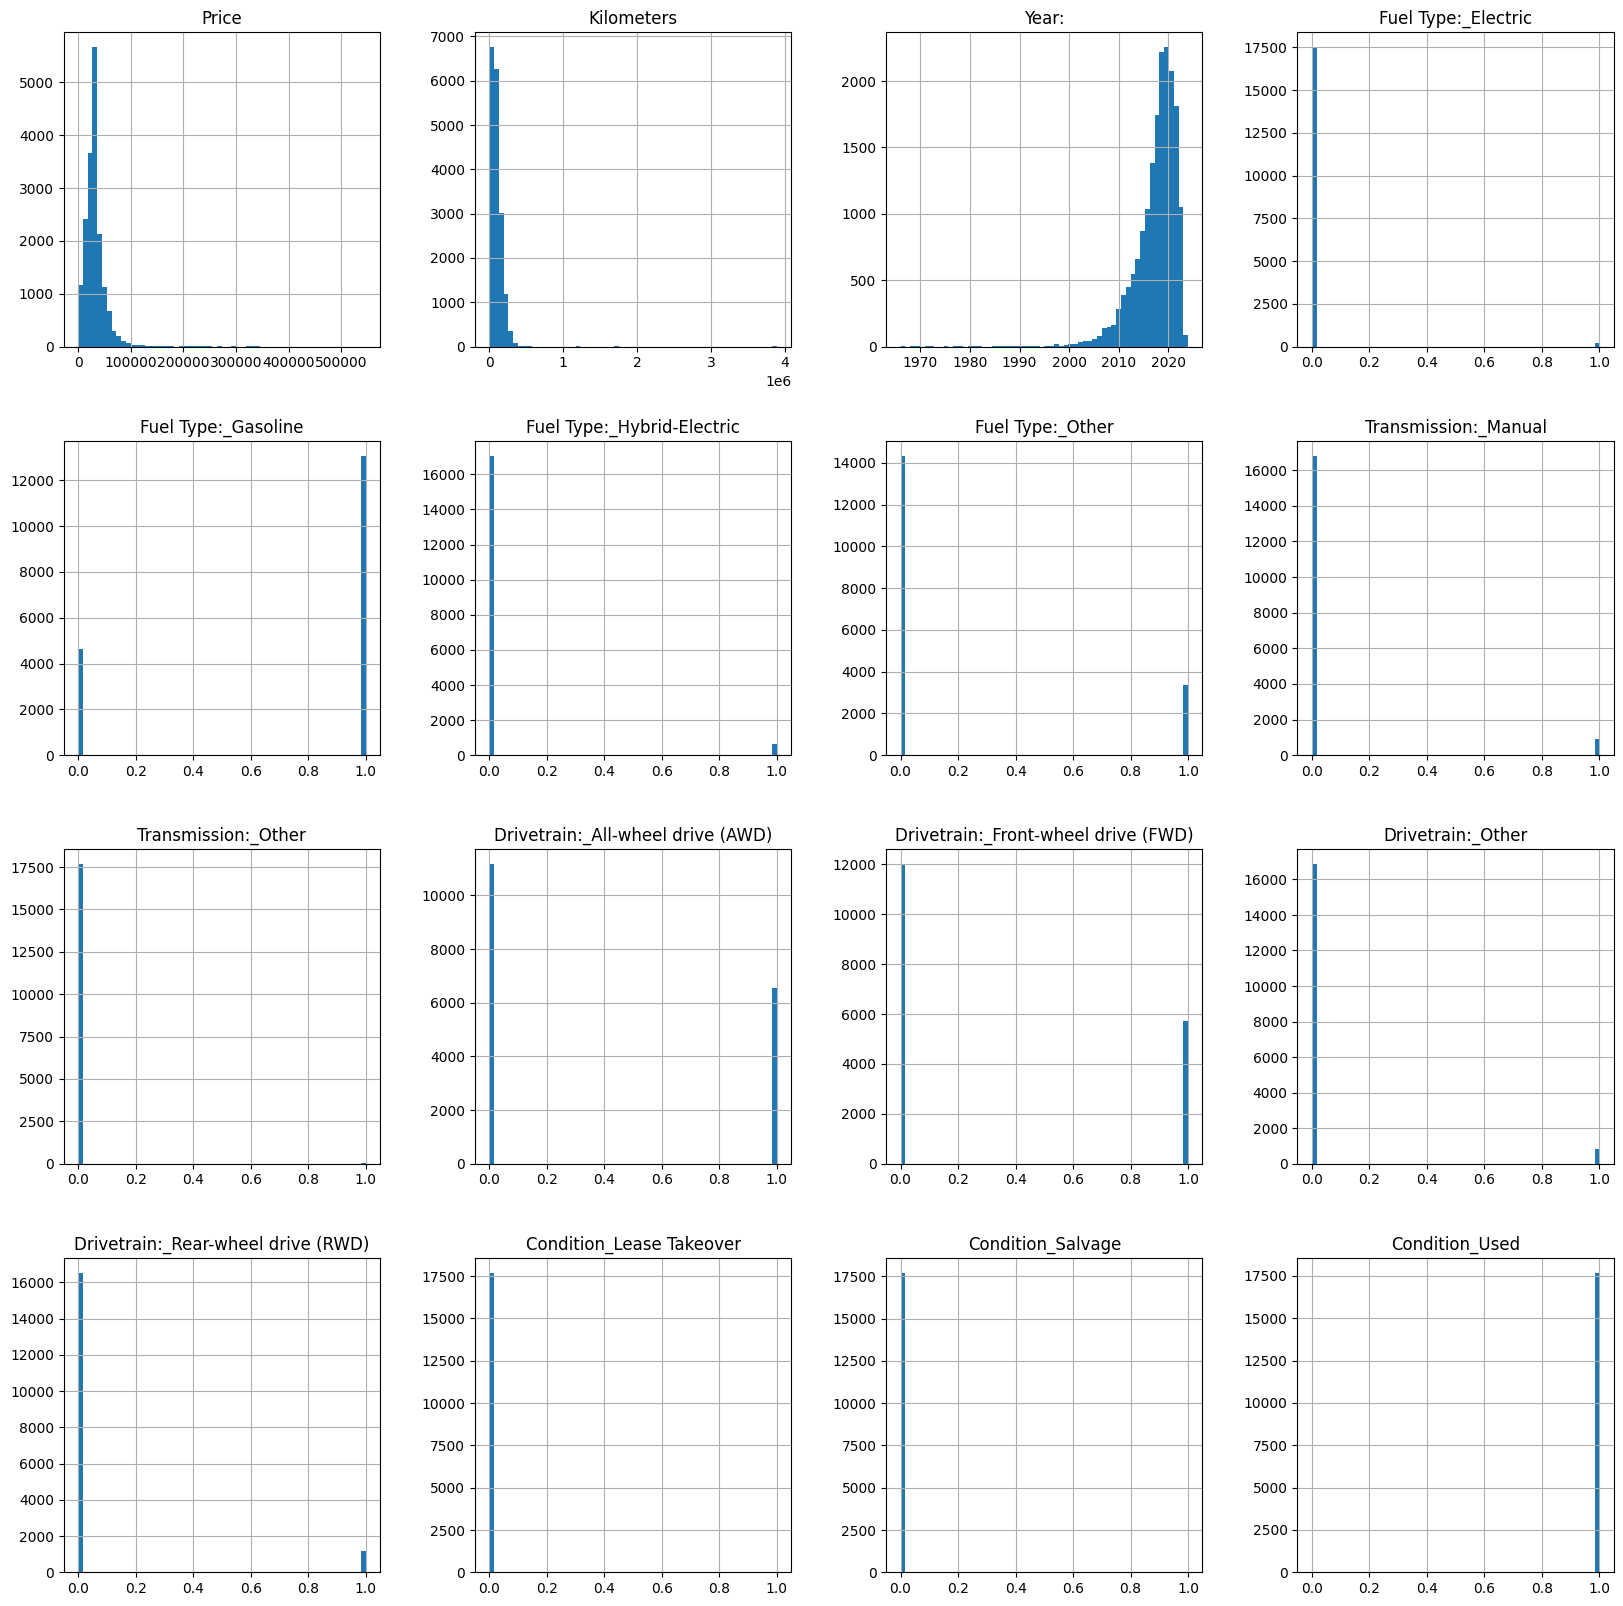

In [39]:
df.hist(bins=60,figsize=(20,20))

C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\641411736.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<AxesSubplot: >

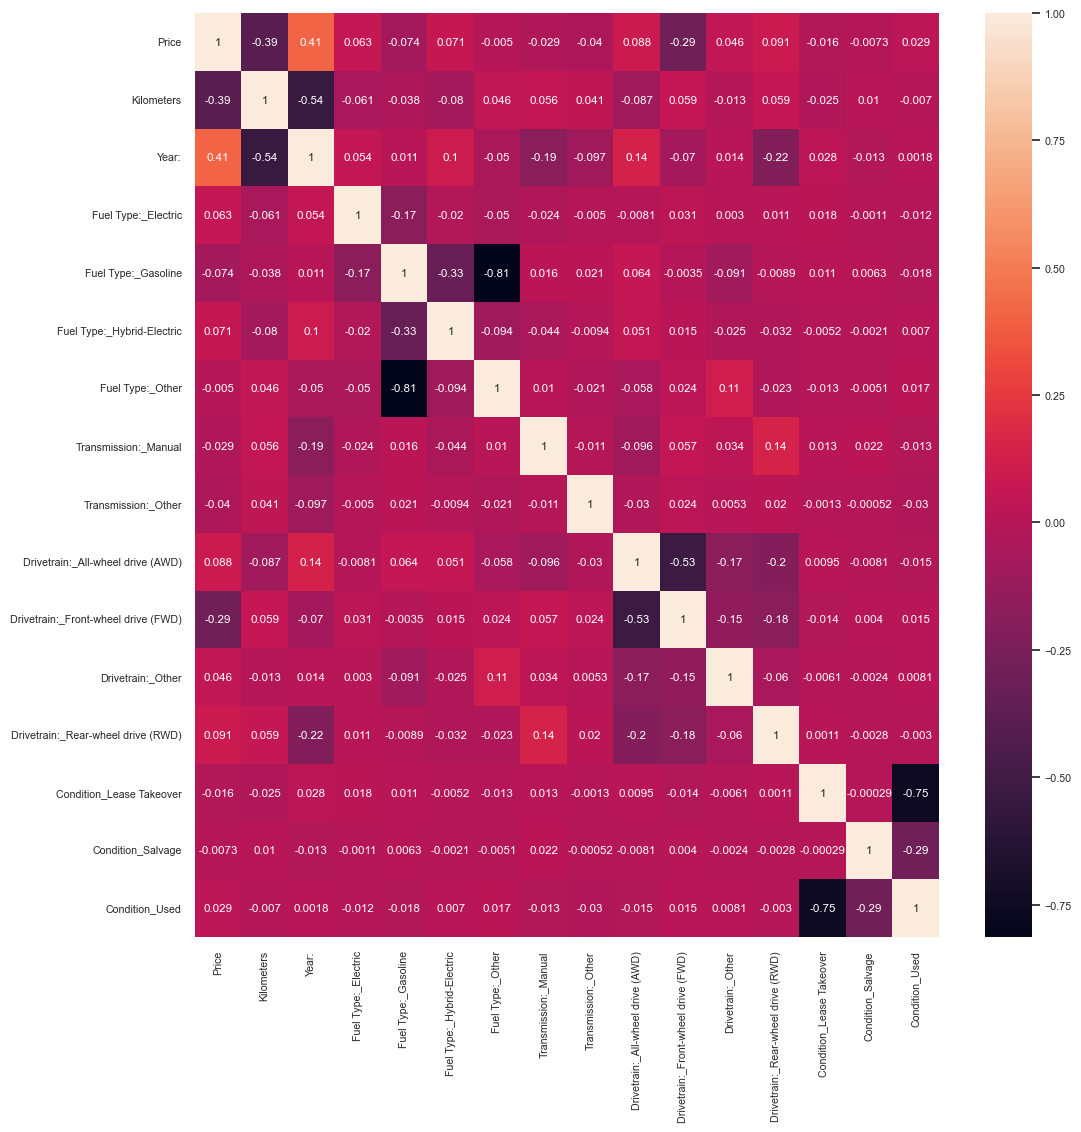

In [40]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=0.7)
sns.heatmap(df.corr(),annot=True)

<AxesSubplot: >

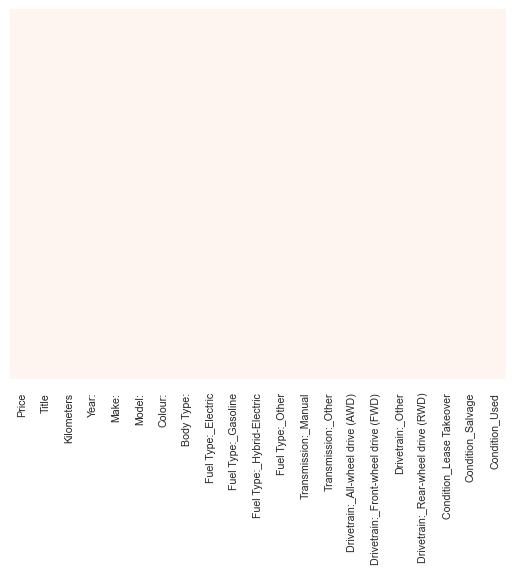

In [41]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Reds")

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17696 entries, 17184 to 16612
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Price                                17696 non-null  float64
 1   Title                                17696 non-null  object 
 2   Kilometers                           17696 non-null  int32  
 3   Year:                                17696 non-null  int64  
 4   Make:                                17696 non-null  object 
 5   Model:                               17696 non-null  object 
 6   Colour:                              17696 non-null  object 
 7   Body Type:                           17696 non-null  object 
 8   Fuel Type:_Electric                  17696 non-null  uint8  
 9   Fuel Type:_Gasoline                  17696 non-null  uint8  
 10  Fuel Type:_Hybrid-Electric           17696 non-null  uint8  
 11  Fuel Type:_Other        

# Identifying outliers

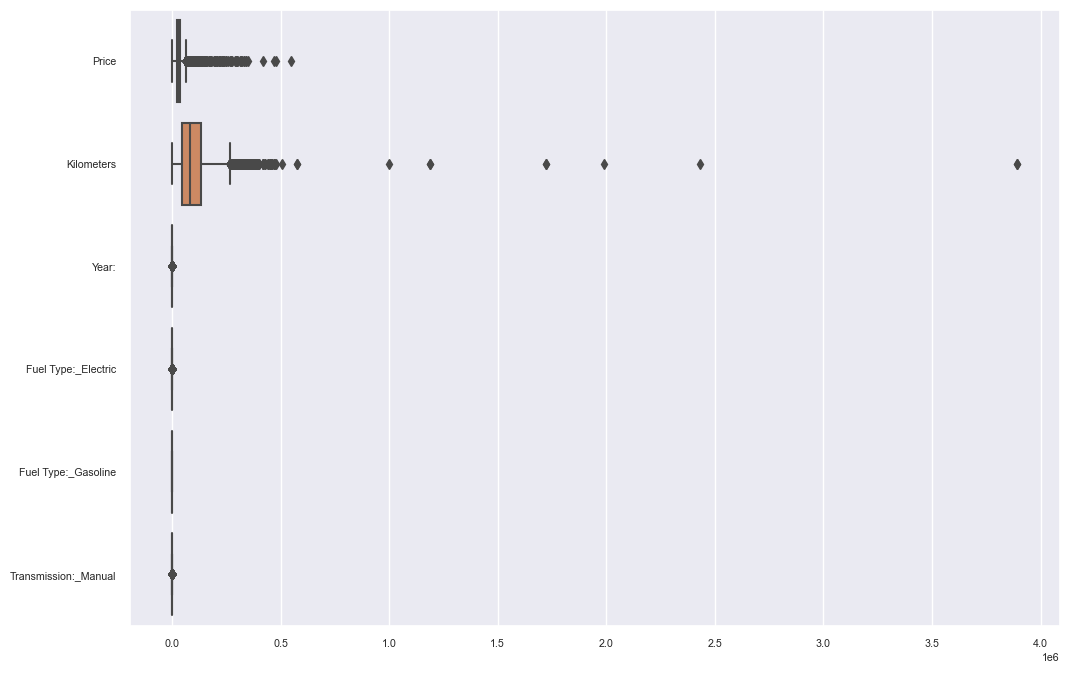

In [43]:
#Selecting the columns
df_selected = df[['Price', 'Kilometers', 'Year:', 'Fuel Type:_Electric', 'Fuel Type:_Gasoline', 'Transmission:_Manual']]

# Creating box plots for the selected columns
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected, orient="h")
plt.show()

# From the above Box Plot we can see that there are outliers in the column kilometers and price

In [44]:
#Looking duplicated in the dataframe
print(df.duplicated().sum()) # counting the duplicate rows
df.duplicated()

5470


17184    False
21401    False
12496    False
17787    False
5568     False
         ...  
395       True
21927    False
16624    False
6438      True
16612     True
Length: 17696, dtype: bool

In [45]:
df.loc[df.duplicated(), :] # extracting the duplicated observations.

,Price,Title,Kilometers,Year:,Make:,Model:,Colour:,Body Type:,Fuel Type:_Electric,Fuel Type:_Gasoline,...,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used
5546,102000.0,1971 Plymouth GTX RWD | POWER WINDOWS | SATEL...,42700,1971,Plymouth,GTX,Blue,Coupe (2 door),0,1,...,0,0,0,0,1,0,0,0,0,1
15901,42995.0,1972 Chevrolet Nova FRESH 383ci performance en...,96779,1972,Chevrolet,Nova,Black,Coupe (2 door),0,0,...,1,0,0,0,0,0,1,0,0,1
19917,12898.0,1980 FIAT 124 Spider Unknown,97663,1980,Fiat,124 Spider,Black,Other,0,1,...,0,1,0,0,0,0,1,0,0,1
6308,3200.0,1985 Toyota Cressida MX73 Executive rust free ...,225000,1985,Toyota,Other,Grey,Sedan,0,1,...,0,1,0,0,0,0,1,0,0,1
12812,20000.0,1987 Ford Mustang LX,80000,1987,Ford,Mustang,Yellow,Convertible,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,58888.0,2024 Nissan Pathfinder,111,2024,Nissan,Pathfinder,Beige,Other,0,0,...,1,0,0,0,0,0,0,0,0,1
6487,60990.0,2024 Lexus NX 350,5791,2024,Lexus,Other,Black,"SUV, Crossover",0,1,...,0,0,0,1,0,0,0,0,0,1
395,35900.0,2024 Honda Civic,1467,2024,Honda,Civic,Silver,Sedan,0,1,...,0,0,0,0,0,1,0,0,0,1
6438,60990.0,2024 Lexus NX 350,5791,2024,Lexus,Other,Black,"SUV, Crossover",0,1,...,0,0,0,1,0,0,0,0,0,1


In [46]:
#Dropping the duplicates
df.drop_duplicates(inplace=True)
df.shape

(12226, 21)

- After dropping the duplicate values our new length was 12226.

In [47]:
# Label Encoding the remaining columns i.e Make, Model, COlour and Body Type
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['Make:'] = labelencoder.fit_transform(df['Make:'])
df['Model:'] = labelencoder.fit_transform(df['Model:'])
df['Colour:'] = labelencoder.fit_transform(df['Colour:'])
df['Body Type:'] = labelencoder.fit_transform(df['Body Type:'])

print(df)

          Price                                              Title  \
17184   90000.0  1966 Mercedes-Benz 230 SL "Pagoda"  Stunning v...   
21401   24995.0   1968 Ford F-250 *MERCURY M250*GREAT CONDITION...   
12496  109800.0  1969 Chevrolet Camaro Z/28 302 4-SPEED, NUMBER...   
17787   21000.0  1969 Volkswagen Beetle " Extremely Rare Automa...   
5568   102000.0   1971 Plymouth GTX RWD | POWER WINDOWS | SATEL...   
...         ...                                                ...   
21899   71888.0                      2024 Jeep Wrangler 4xe Sahara   
9430    51998.0  2024 Mazda CX-90 MHEV GS-L Mild Hybrid AWD - 2...   
9426    40888.0                             2024 Honda Civic Sedan   
21927   92712.0                       2024 Jeep Wrangler Rubicon X   
16624   55900.0                        2024 Toyota RAV4 Hybrid XLE   

       Kilometers  Year:  Make:  Model:  Colour:  Body Type:  \
17184      122000   1966     32     391        1           0   
21401       70585   1968     13

In [48]:
df.head()

,Price,Title,Kilometers,Year:,Make:,Model:,Colour:,Body Type:,Fuel Type:_Electric,Fuel Type:_Gasoline,...,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used
17184,90000.0,"1966 Mercedes-Benz 230 SL ""Pagoda"" Stunning v...",122000,1966,32,391,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
21401,24995.0,1968 Ford F-250 *MERCURY M250*GREAT CONDITION...,70585,1968,13,169,2,5,0,1,...,0,0,0,0,0,0,1,0,0,1
12496,109800.0,"1969 Chevrolet Camaro Z/28 302 4-SPEED, NUMBER...",138190,1969,7,96,9,4,0,0,...,1,1,0,0,0,0,1,0,0,1
17787,21000.0,"1969 Volkswagen Beetle "" Extremely Rare Automa...",84468,1969,51,61,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
5568,102000.0,1971 Plymouth GTX RWD | POWER WINDOWS | SATEL...,42700,1971,38,210,2,1,0,1,...,0,0,0,0,1,0,0,0,0,1


- Now we have df after one hot encoding removing duplicates and label encoding.

In [49]:
#Looking for the columns after label encoding
column_types = df.dtypes
print(column_types)


Price                                  float64
Title                                   object
Kilometers                               int32
Year:                                    int64
Make:                                    int32
Model:                                   int32
Colour:                                  int32
Body Type:                               int32
Fuel Type:_Electric                      uint8
Fuel Type:_Gasoline                      uint8
Fuel Type:_Hybrid-Electric               uint8
Fuel Type:_Other                         uint8
Transmission:_Manual                     uint8
Transmission:_Other                      uint8
Drivetrain:_All-wheel drive (AWD)        uint8
Drivetrain:_Front-wheel drive (FWD)      uint8
Drivetrain:_Other                        uint8
Drivetrain:_Rear-wheel drive (RWD)       uint8
Condition_Lease Takeover                 uint8
Condition_Salvage                        uint8
Condition_Used                           uint8
dtype: object

# Addressing outliers

In [50]:
#IQR
df_new = df.copy()
columns=['Price', 'Kilometers', 'Year:', 'Make:', 'Model:', 'Colour:',
       'Body Type:', 'Fuel Type:_Electric', 'Fuel Type:_Gasoline',
       'Fuel Type:_Hybrid-Electric', 'Fuel Type:_Other',
       'Transmission:_Manual', 'Transmission:_Other',
       'Drivetrain:_All-wheel drive (AWD)',
       'Drivetrain:_Front-wheel drive (FWD)', 'Drivetrain:_Other',
       'Drivetrain:_Rear-wheel drive (RWD)', 'Condition_Lease Takeover',
       'Condition_Salvage', 'Condition_Used']

for c in columns:
    df_table = df_new[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q1 + 1.5*IQR

    outliers_number = (( df_table < (lower_bound)) | (df_table > (upper_bound))).sum()
    outliers_number

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))

    percentage = round((100*outliers_number) / (len(df_table)),2)
    print(str(outliers_number) + " of " + str(len(df_table)) + " is outlier (%" + str(percentage) + ")")


Price
lower_bound is -6987.5
upper_bound is 46985.5
Q1 is : 19999.0
Q3 is : 37990.0
1709 of 12226 is outlier (%13.98)

Kilometers
lower_bound is -94737.75
upper_bound is 184884.75
Q1 is : 45073.5
Q3 is : 138281.0
1482 of 12226 is outlier (%12.12)

Year:
lower_bound is 2008.5
upper_bound is 2023.5
Q1 is : 2016.0
Q3 is : 2021.0
579 of 12226 is outlier (%4.74)

Make:
lower_bound is -20.0
upper_bound is 46.0
Q1 is : 13.0
Q3 is : 35.0
1981 of 12226 is outlier (%16.2)

Model:
lower_bound is -262.0
upper_bound is 488.0
Q1 is : 113.0
Q3 is : 363.0
187 of 12226 is outlier (%1.53)

Colour:
lower_bound is -19.0
upper_bound is 23.0
Q1 is : 2.0
Q3 is : 16.0
0 of 12226 is outlier (%0.0)

Body Type:
lower_bound is 2.0
upper_bound is 8.0
Q1 is : 5.0
Q3 is : 7.0
601 of 12226 is outlier (%4.92)

Fuel Type:_Electric
lower_bound is 0.0
upper_bound is 0.0
Q1 is : 0.0
Q3 is : 0.0
129 of 12226 is outlier (%1.06)

Fuel Type:_Gasoline
lower_bound is -1.5
upper_bound is 1.5
Q1 is : 0.0
Q3 is : 1.0
0 of 12226 i

In [51]:
Q1 = df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1

# Filtering values between Q1-1.5*IQR and Q3+1.5*IQR
df= df_new[~((df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))).any(axis=1)]


C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\1802602315.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df_new.quantile(0.25)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\1802602315.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df_new.quantile(0.75)
C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\1802602315.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df= df_new[~((df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))).any(axis=1)

In [52]:
df_new = df.copy()
columns=['Price', 'Kilometers', 'Year:', 'Make:', 'Model:', 'Colour:',
       'Body Type:', 'Fuel Type:_Electric', 'Fuel Type:_Gasoline',
       'Fuel Type:_Hybrid-Electric', 'Fuel Type:_Other',
       'Transmission:_Manual', 'Transmission:_Other',
       'Drivetrain:_All-wheel drive (AWD)',
       'Drivetrain:_Front-wheel drive (FWD)', 'Drivetrain:_Other',
       'Drivetrain:_Rear-wheel drive (RWD)', 'Condition_Lease Takeover',
       'Condition_Salvage', 'Condition_Used']

for c in columns:
    df_table = df_new[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q1 + 1.5*IQR

    outliers_number = (( df_table < (lower_bound)) | (df_table > (upper_bound))).sum()
    outliers_number

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))

    percentage = round((100*outliers_number) / (len(df_table)),2)
    print(str(outliers_number) + " of " + str(len(df_table)) + " is outlier (%" + str(percentage) + ")")


Price
lower_bound is 995.0
upper_bound is 42995.0
Q1 is : 21995.0
Q3 is : 35995.0
946 of 7086 is outlier (%13.35)

Kilometers
lower_bound is -75611.625
upper_bound is 168611.625
Q1 is : 46500.0
Q3 is : 127907.75
878 of 7086 is outlier (%12.39)

Year:
lower_bound is 2011.0
upper_bound is 2023.0
Q1 is : 2017.0
Q3 is : 2021.0
179 of 7086 is outlier (%2.53)

Make:
lower_bound is -20.0
upper_bound is 46.0
Q1 is : 13.0
Q3 is : 35.0
1108 of 7086 is outlier (%15.64)

Model:
lower_bound is -252.125
upper_bound is 494.125
Q1 is : 121.0
Q3 is : 369.75
83 of 7086 is outlier (%1.17)

Colour:
lower_bound is -14.5
upper_bound is 18.5
Q1 is : 2.0
Q3 is : 13.0
0 of 7086 is outlier (%0.0)

Body Type:
lower_bound is 4.5
upper_bound is 7.5
Q1 is : 6.0
Q3 is : 7.0
1028 of 7086 is outlier (%14.51)

Fuel Type:_Electric
lower_bound is 0.0
upper_bound is 0.0
Q1 is : 0.0
Q3 is : 0.0
0 of 7086 is outlier (%0.0)

Fuel Type:_Gasoline
lower_bound is 1.0
upper_bound is 1.0
Q1 is : 1.0
Q3 is : 1.0
137 of 7086 is out

- The outliers were properly addressed with IQR.

In [53]:
#Trimming
df_trimmed = df.copy()
columns=['Price', 'Kilometers', 'Year:', 'Make:', 'Model:', 'Colour:',
       'Body Type:', 'Fuel Type:_Electric', 'Fuel Type:_Gasoline',
       'Fuel Type:_Hybrid-Electric', 'Fuel Type:_Other',
       'Transmission:_Manual', 'Transmission:_Other',
       'Drivetrain:_All-wheel drive (AWD)',
       'Drivetrain:_Front-wheel drive (FWD)', 'Drivetrain:_Other',
       'Drivetrain:_Rear-wheel drive (RWD)', 'Condition_Lease Takeover',
       'Condition_Salvage', 'Condition_Used']

for c in columns:
    df_table = df_trimmed[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Trimming
    df_trimmed[c] = df_table.clip(lower=lower_bound, upper=upper_bound)

    outliers_number = ((df_table < lower_bound) | (df_table > upper_bound)).sum()

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))

    percentage = round((100 * outliers_number) / len(df_table), 2)
    print(str(outliers_number) + " of " + str(len(df_table)) + " is an outlier (%" + str(percentage) + ")")




Price
lower_bound is 995.0
upper_bound is 56995.0
Q1 is : 21995.0
Q3 is : 35995.0
175 of 7086 is an outlier (%2.47)

Kilometers
lower_bound is -75611.625
upper_bound is 250019.375
Q1 is : 46500.0
Q3 is : 127907.75
80 of 7086 is an outlier (%1.13)

Year:
lower_bound is 2011.0
upper_bound is 2027.0
Q1 is : 2017.0
Q3 is : 2021.0
164 of 7086 is an outlier (%2.31)

Make:
lower_bound is -20.0
upper_bound is 68.0
Q1 is : 13.0
Q3 is : 35.0
0 of 7086 is an outlier (%0.0)

Model:
lower_bound is -252.125
upper_bound is 742.875
Q1 is : 121.0
Q3 is : 369.75
0 of 7086 is an outlier (%0.0)

Colour:
lower_bound is -14.5
upper_bound is 29.5
Q1 is : 2.0
Q3 is : 13.0
0 of 7086 is an outlier (%0.0)

Body Type:
lower_bound is 4.5
upper_bound is 8.5
Q1 is : 6.0
Q3 is : 7.0
893 of 7086 is an outlier (%12.6)

Fuel Type:_Electric
lower_bound is 0.0
upper_bound is 0.0
Q1 is : 0.0
Q3 is : 0.0
0 of 7086 is an outlier (%0.0)

Fuel Type:_Gasoline
lower_bound is 1.0
upper_bound is 1.0
Q1 is : 1.0
Q3 is : 1.0
137 of

In [54]:
#log transformation
df_log = df_new
columns = ['Price', 'Kilometers']

for c in columns:
    df_table = df_log[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_number = ((df_table < lower_bound) | (df_table > upper_bound)).sum()

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))

    percentage = round((100 * outliers_number) / len(df_table), 2)
    print(str(outliers_number) + " of " + str(len(df_table)) + " is an outlier (%" + str(percentage) + ")")

    # Log transformation
    df_log[c]= df_table.apply(lambda x: np.log(x) if x > 0 else x)


Price
lower_bound is 995.0
upper_bound is 56995.0
Q1 is : 21995.0
Q3 is : 35995.0
175 of 7086 is an outlier (%2.47)

Kilometers
lower_bound is -75611.625
upper_bound is 250019.375
Q1 is : 46500.0
Q3 is : 127907.75
80 of 7086 is an outlier (%1.13)


In [55]:
#log transformation
columns = ['Price', 'Kilometers']

for c in columns:
    df_table = df_log[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_number = ((df_table < lower_bound) | (df_table > upper_bound)).sum()

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))

    percentage = round((100 * outliers_number) / len(df_table), 2)
    print(str(outliers_number) + " of " + str(len(df_table)) + " is an outlier (%" + str(percentage) + ")")


Price
lower_bound is 9.259723106101946
upper_bound is 11.229982646584277
Q1 is : 9.99857043378282
Q3 is : 10.491135318903403
416 of 7086 is an outlier (%5.87)

Kilometers
lower_bound is 9.229422136951285
upper_bound is 13.276850015949051
Q1 is : 10.747207591575448
Q3 is : 11.75906456132489
367 of 7086 is an outlier (%5.18)


- For our data IQR performed better than log transformation.
- The outliers were addressed properly with IQR whereas log transfromation could not address the outliers.
- The percentage of outliers increased with log transformation.

In [56]:
from sklearn.preprocessing import StandardScaler
# Separating numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64','uint8']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Scaling the numerical columns
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)

# Concatenating the scaled numerical data with the categorical data
df= pd.concat([df_scaled, df[categorical_columns]], axis=1)


In [57]:
df.head()

,Price,Year:,Fuel Type:_Electric,Fuel Type:_Gasoline,Fuel Type:_Hybrid-Electric,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used,Title
0,-1.396973,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,NaN
1,-0.786657,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0,NaN
2,-2.226696,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,NaN
3,-0.566836,-2.904325,0.0,-7.121982,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0,2020 Volkswagen Tiguan
4,-2.334614,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,NaN


In [58]:
#Dropping the label Title
df = df.drop(['Title'], axis=1)

In [59]:
df.head()

,Price,Year:,Fuel Type:_Electric,Fuel Type:_Gasoline,Fuel Type:_Hybrid-Electric,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used
0,-1.396973,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0
1,-0.786657,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0
2,-2.226696,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0
3,-0.566836,-2.904325,0.0,-7.121982,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0
4,-2.334614,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0


C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\skl

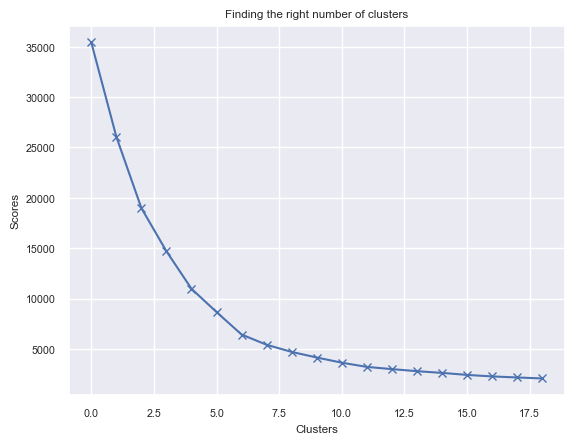

In [60]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
scores_1 = []

range_values = range(1, 20)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(df_imputed)
  scores_1.append(kmeans.inertia_)

plt.plot(scores_1, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.show()

- From this we can observe that, 5th cluster seems to be forming the elbow of the curve.
- However, the values does not reduce linearly until 8th cluster.

In [61]:
# Assigning the number of clusters and fitting the dataframe into model
kmeans = KMeans(8)
kmeans.fit(df_imputed)
labels = kmeans.labels_

C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
# Printing the accuracy
from sklearn.metrics import silhouette_score
print(silhouette_score(df_imputed, labels))

0.6316350596055899


In [63]:
kmeans.cluster_centers_.shape

(8, 15)

In [64]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df.columns])
cluster_centers

,Price,Year:,Fuel Type:_Electric,Fuel Type:_Gasoline,Fuel Type:_Hybrid-Electric,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used
0,-1.336659,-1.374028,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0
1,-0.012912,-0.023274,0.0,0.008798,0.0,0.0,0.0,0.0,-0.056311,-0.045139,0.0,0.0,0.0,0.0,0.0
2,0.032116,0.253436,0.0,0.140410,0.0,0.0,0.0,0.0,1.112724,-0.720396,0.0,0.0,0.0,0.0,0.0
3,0.375494,-0.736619,0.0,-7.121982,0.0,0.0,0.0,0.0,-0.458238,-0.504927,0.0,0.0,0.0,0.0,0.0
4,-0.130361,0.480300,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0
5,1.140313,0.658630,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,-0.718054,0.0,0.0,0.0,0.0,0.0
6,-1.150257,-1.592078,0.0,0.140410,0.0,0.0,0.0,0.0,0.576154,-0.720396,0.0,0.0,0.0,0.0,0.0
7,1.338251,0.840407,0.0,0.140410,0.0,0.0,0.0,0.0,1.112724,-0.720396,0.0,0.0,0.0,0.0,0.0


In [65]:
# to understand what these numbers mean, we perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [df.columns])
cluster_centers

,Price,Year:,Fuel Type:_Electric,Fuel Type:_Gasoline,Fuel Type:_Hybrid-Electric,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used
0,13721.559477,2013.967431,0.0,1.000000e+00,0.0,0.0,0.0,0.0,-4.052314e-15,1.000000e+00,0.0,0.0,0.0,0.0,1.0
1,29667.679586,2018.352054,0.0,9.818775e-01,0.0,0.0,0.0,0.0,4.188006e-01,3.202515e-01,0.0,0.0,0.0,0.0,1.0
2,30210.099599,2019.250272,0.0,1.000000e+00,0.0,0.0,0.0,0.0,1.000000e+00,1.221245e-15,0.0,0.0,0.0,0.0,1.0
3,34346.502522,2016.036496,0.0,5.551115e-16,0.0,0.0,0.0,0.0,2.189781e-01,1.021898e-01,0.0,0.0,0.0,0.0,1.0
4,28252.871513,2019.986684,0.0,1.000000e+00,0.0,0.0,0.0,0.0,-1.720846e-15,1.000000e+00,0.0,0.0,0.0,0.0,1.0
5,43559.660422,2020.565556,0.0,1.000000e+00,0.0,0.0,0.0,0.0,9.992007e-16,1.111111e-03,0.0,0.0,0.0,0.0,1.0
6,15966.992482,2013.259629,0.0,1.000000e+00,0.0,0.0,0.0,0.0,7.332382e-01,1.332268e-15,0.0,0.0,0.0,0.0,1.0
7,45944.061224,2021.155612,0.0,1.000000e+00,0.0,0.0,0.0,0.0,1.000000e+00,8.881784e-16,0.0,0.0,0.0,0.0,1.0


In [66]:
y_kmeans = kmeans.fit_predict(df_imputed)
y_kmeans

C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([4, 6, 4, ..., 1, 1, 1])

In [67]:
df_cluster = pd.concat([df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster.head()

,Price,Year:,Fuel Type:_Electric,Fuel Type:_Gasoline,Fuel Type:_Hybrid-Electric,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used,cluster
0,-1.396973,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.786657,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0,6.0
2,-2.226696,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.566836,-2.904325,0.0,-7.121982,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0,3.0
4,-2.334614,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,0.0


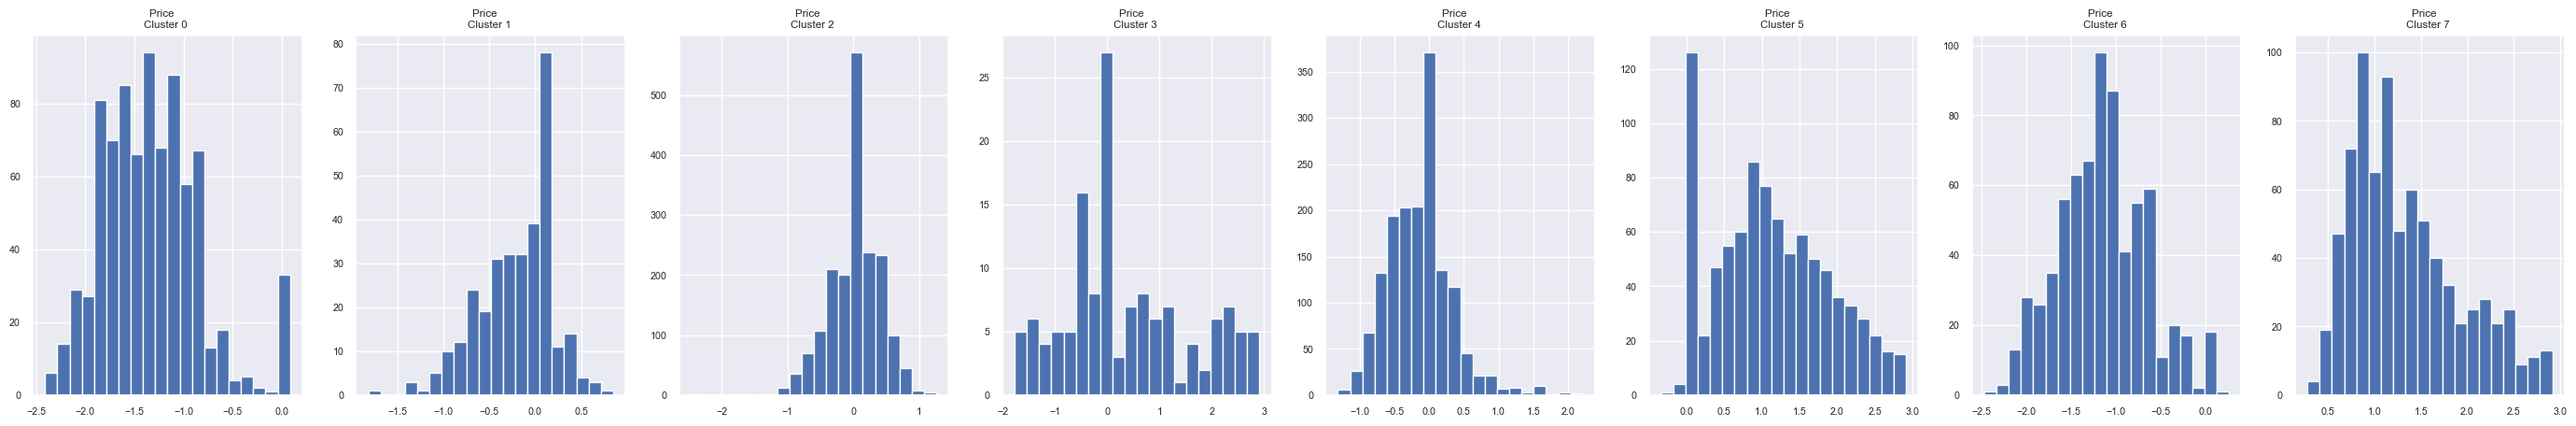

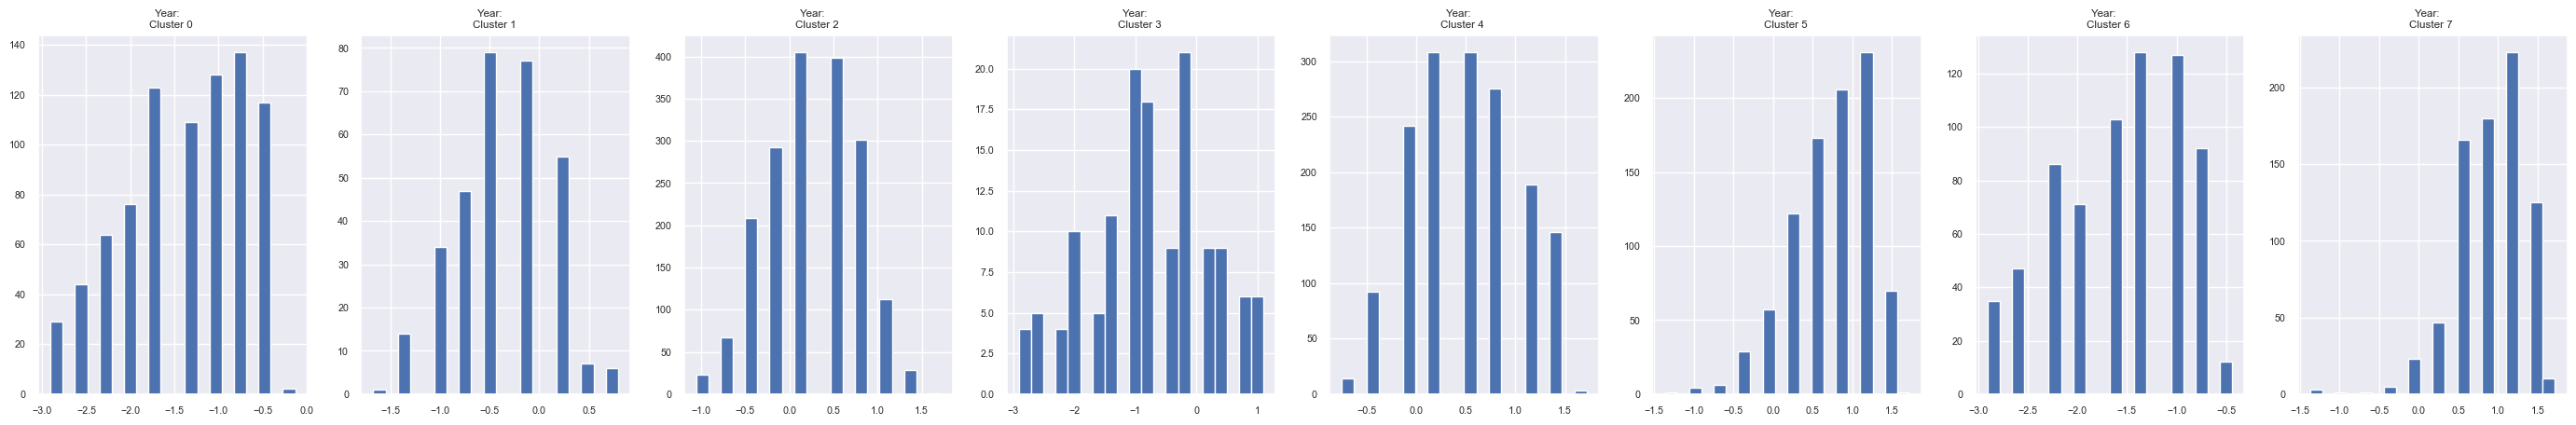

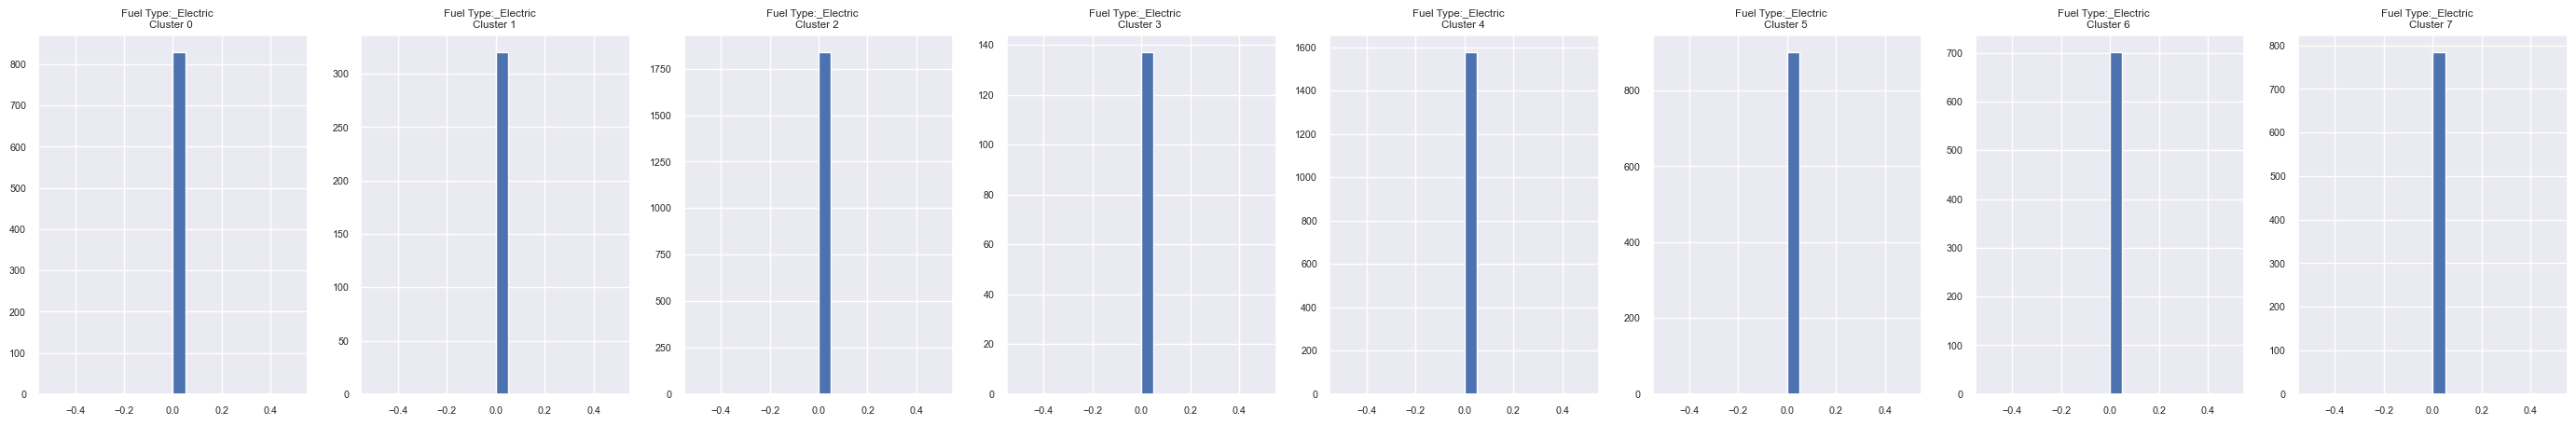

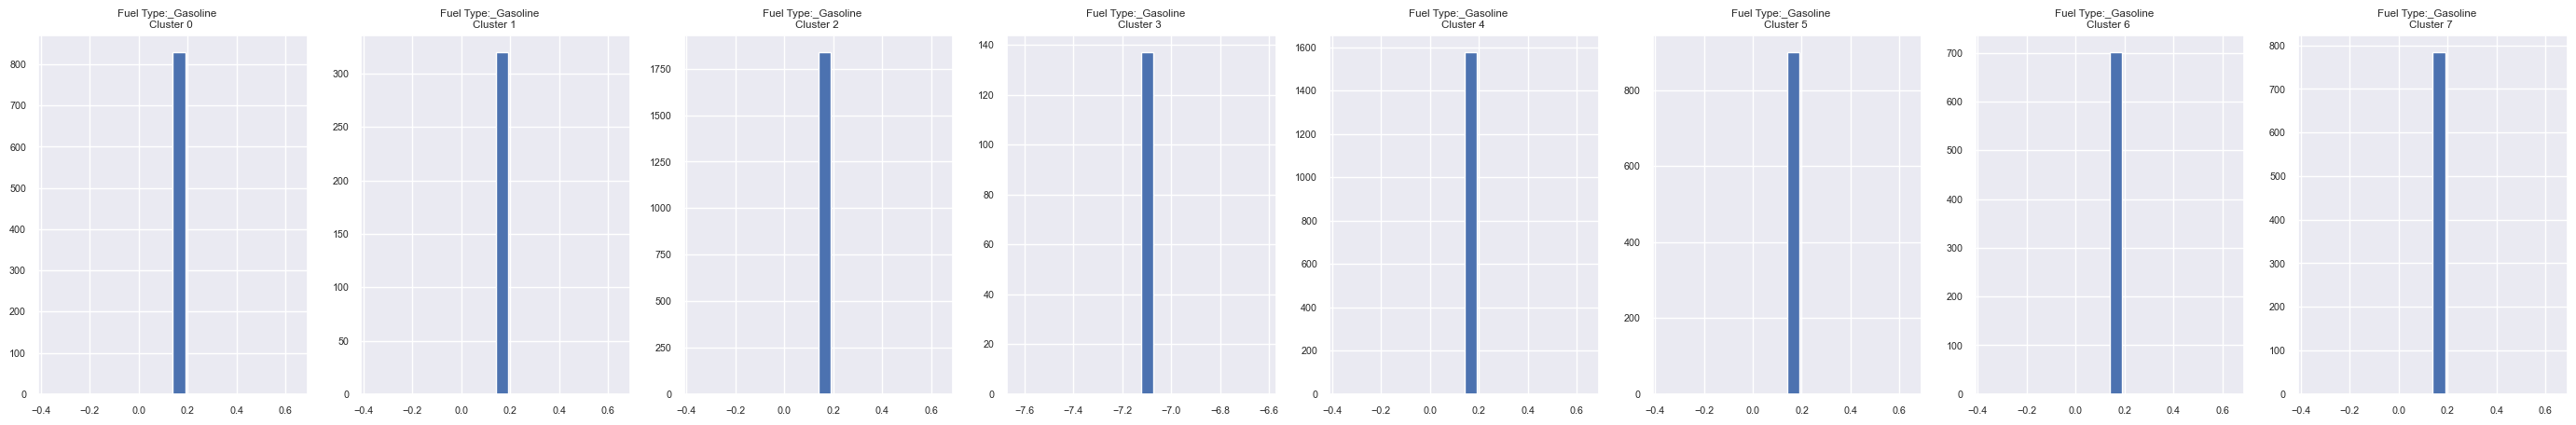

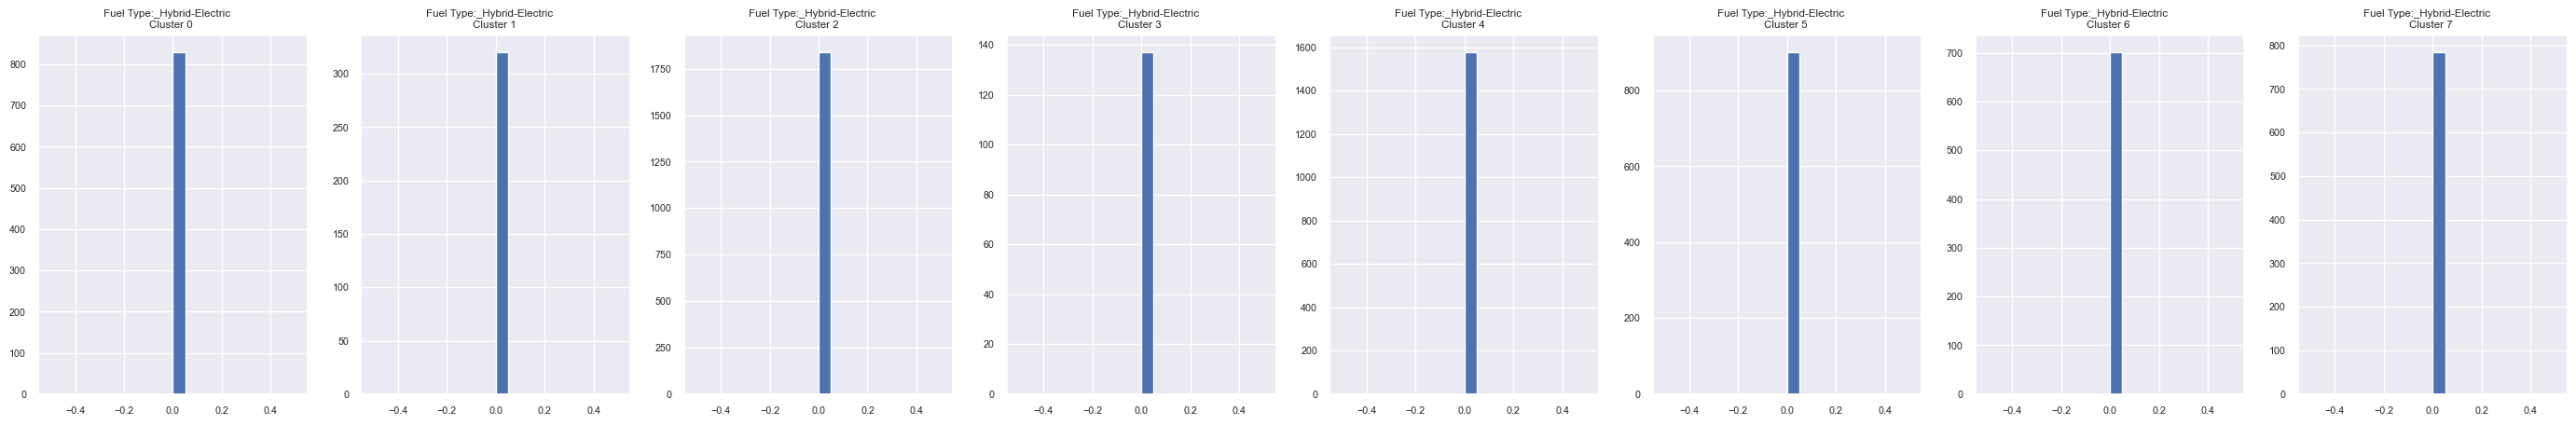

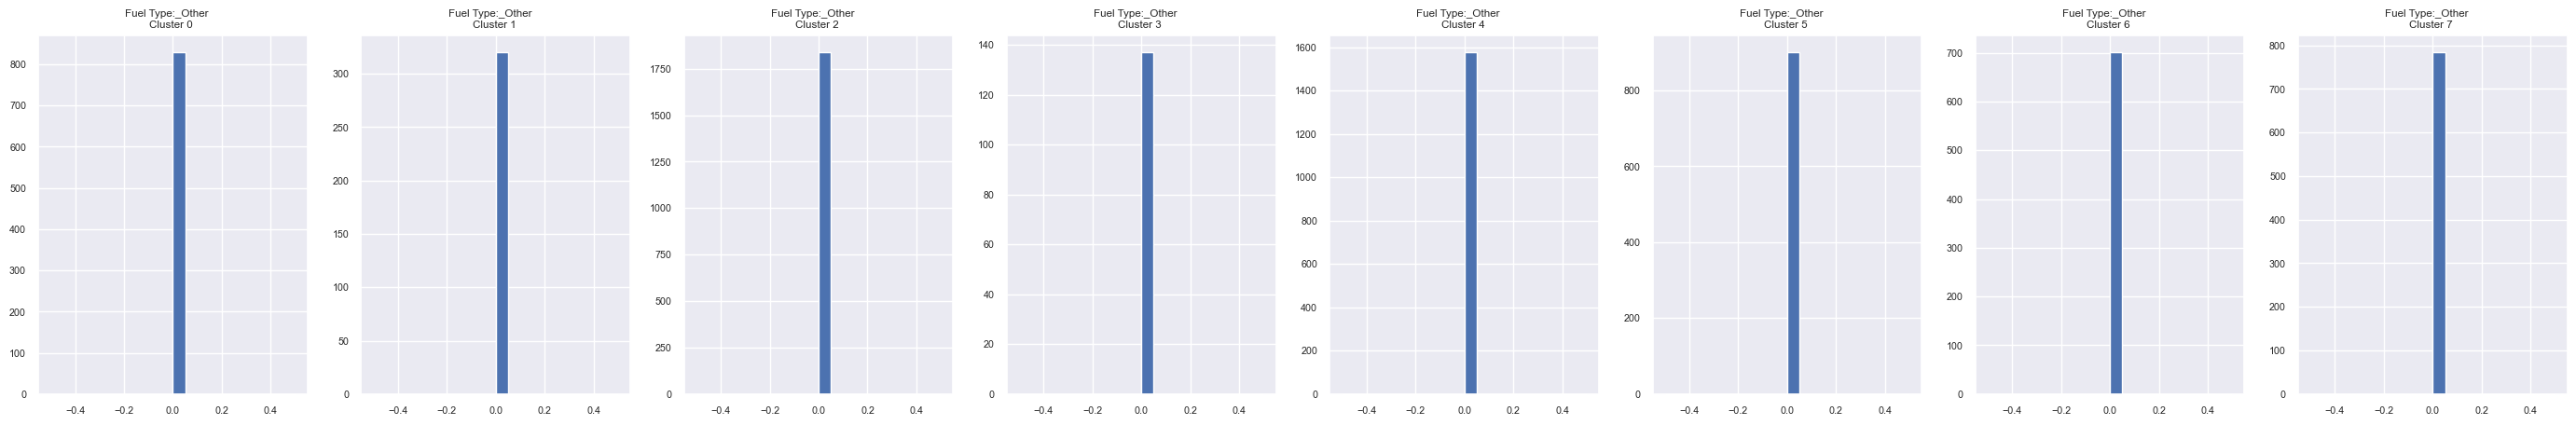

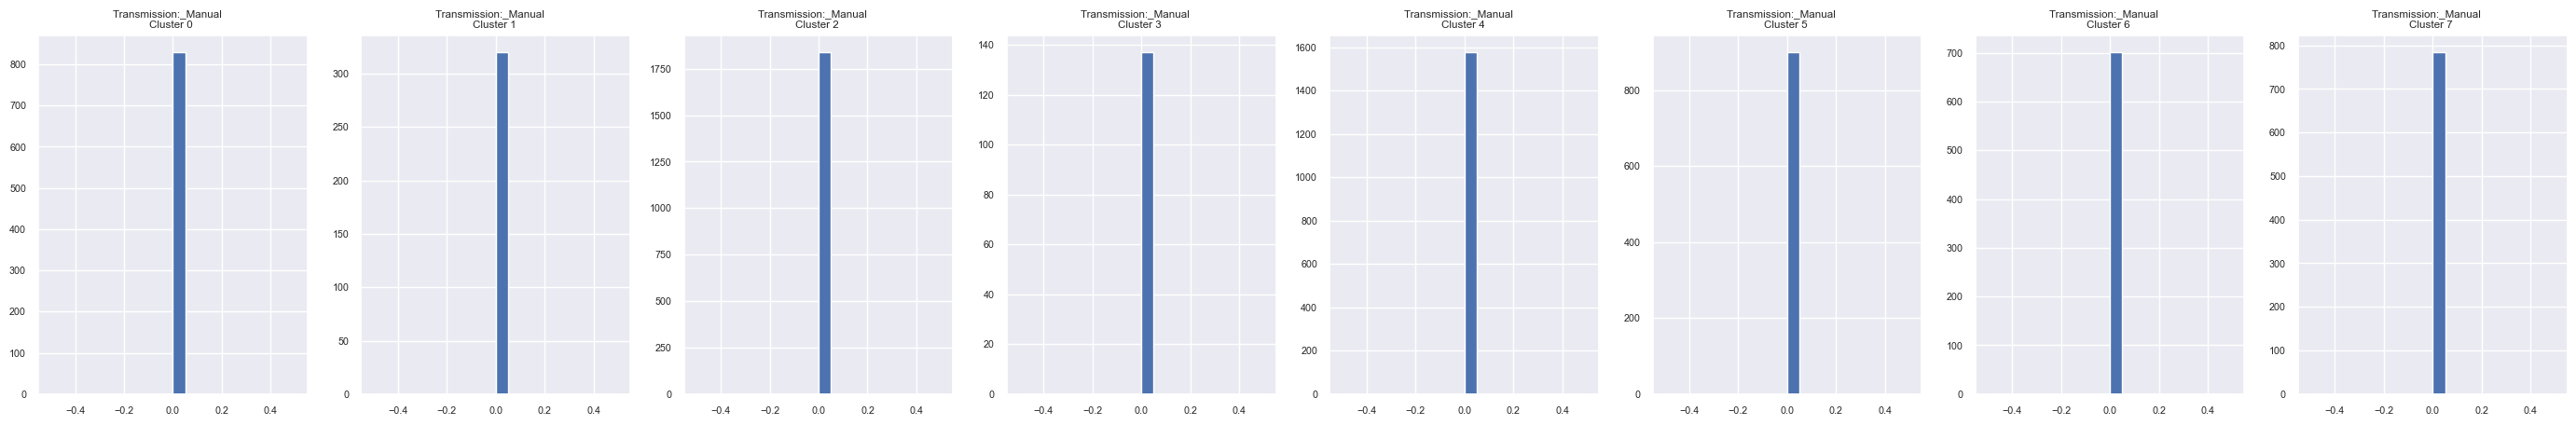

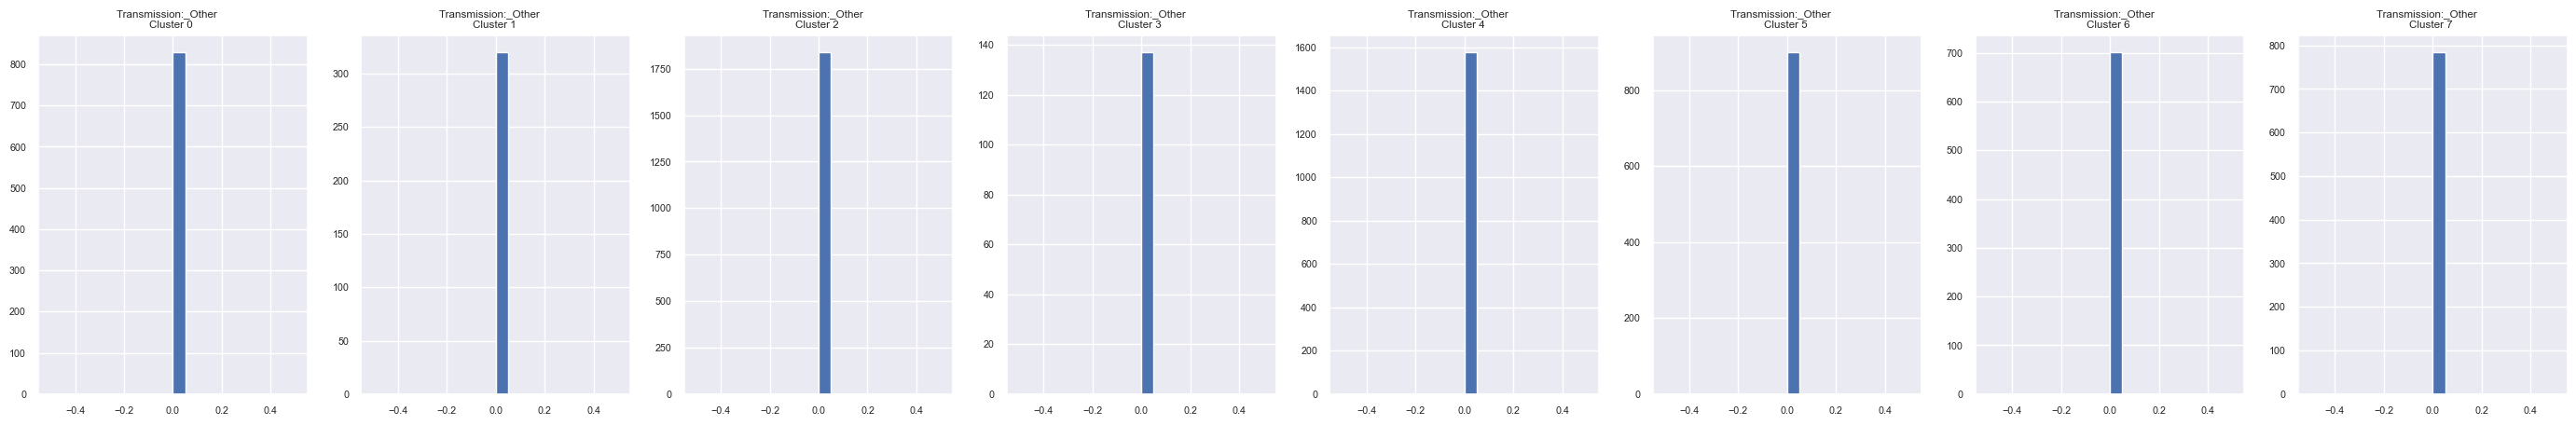

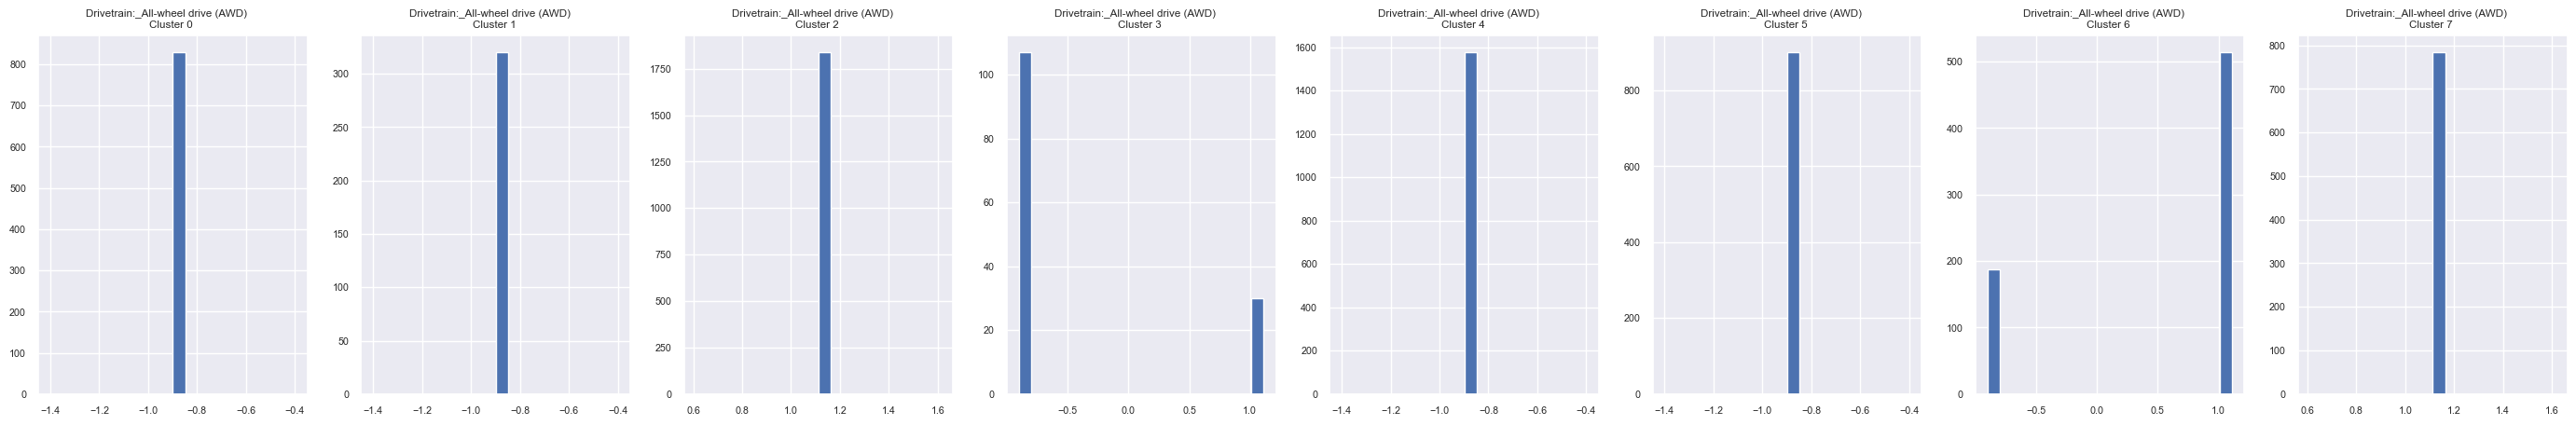

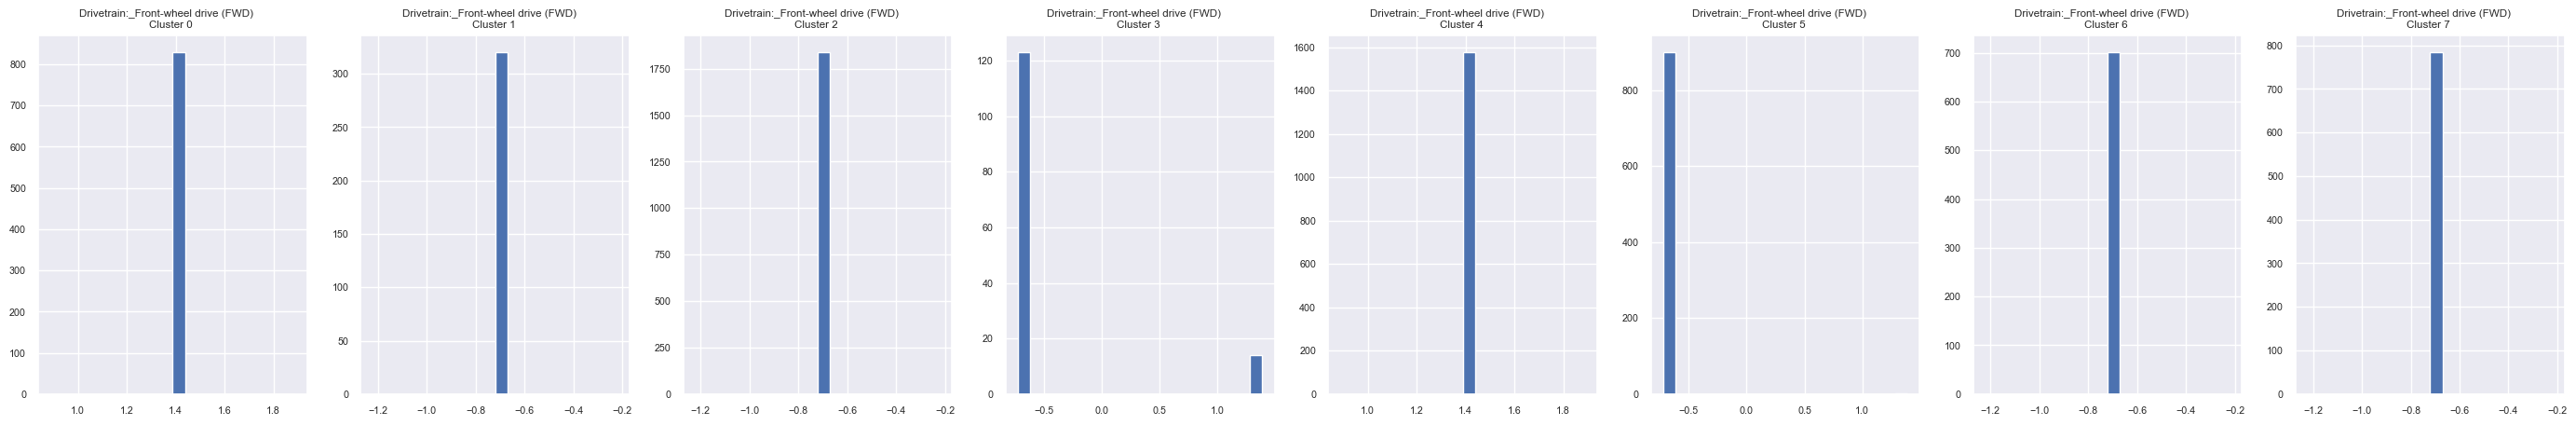

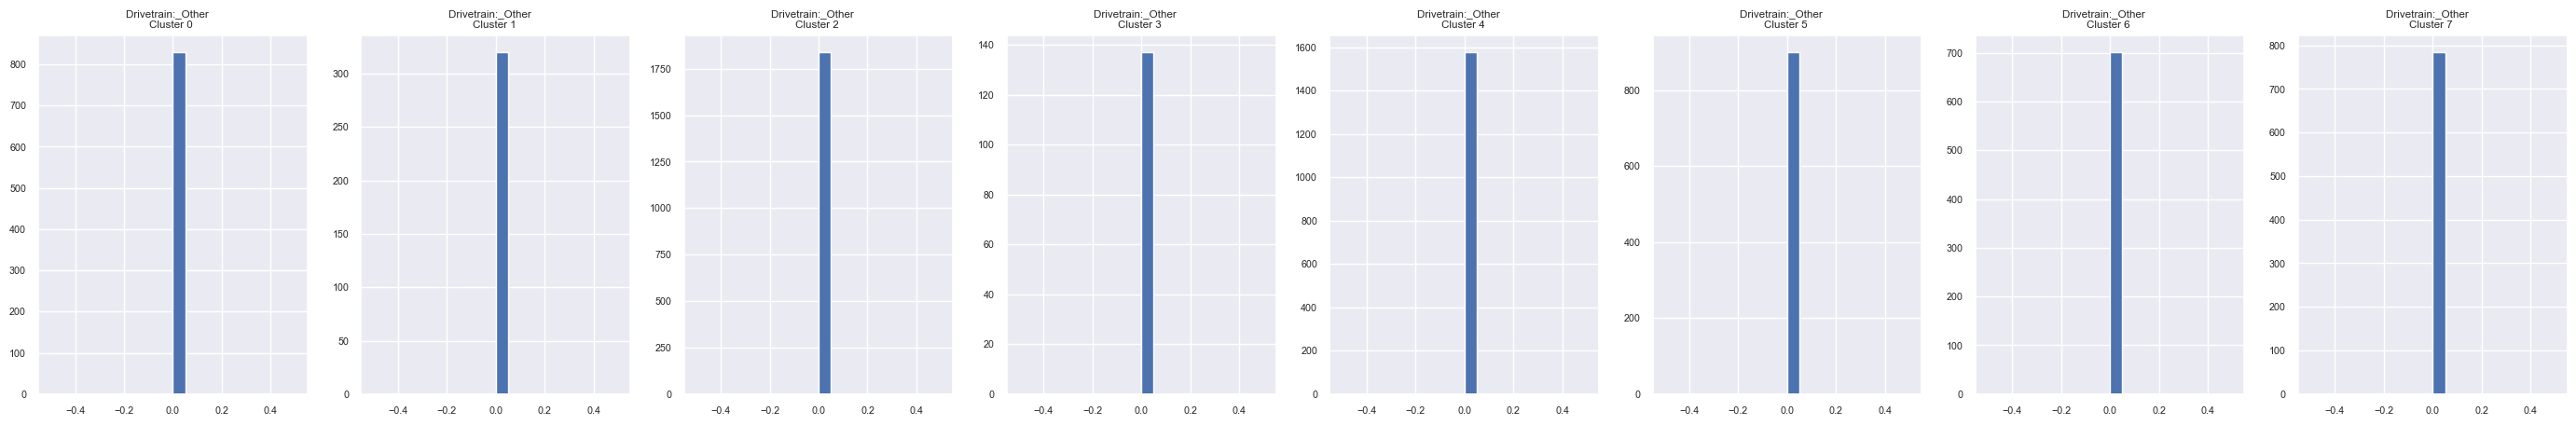

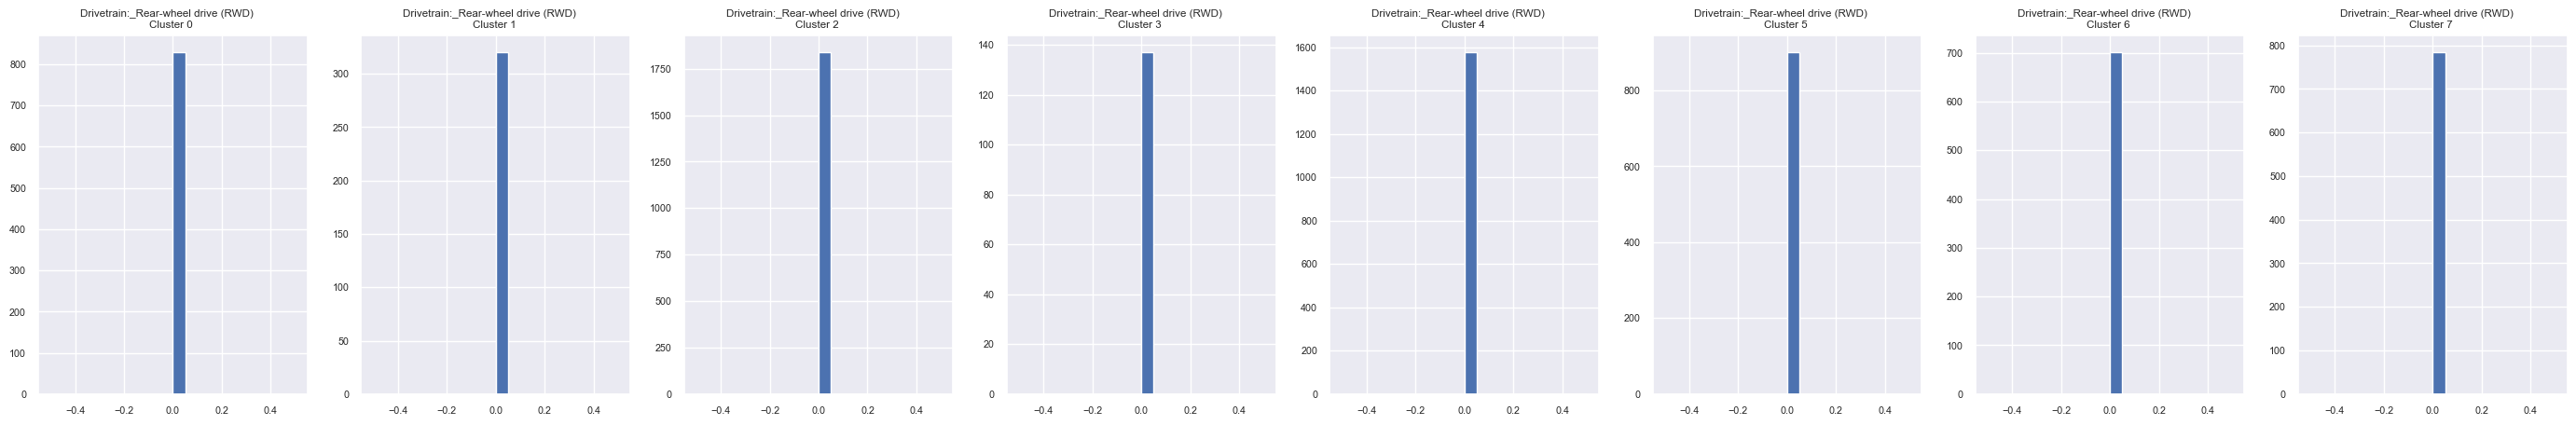

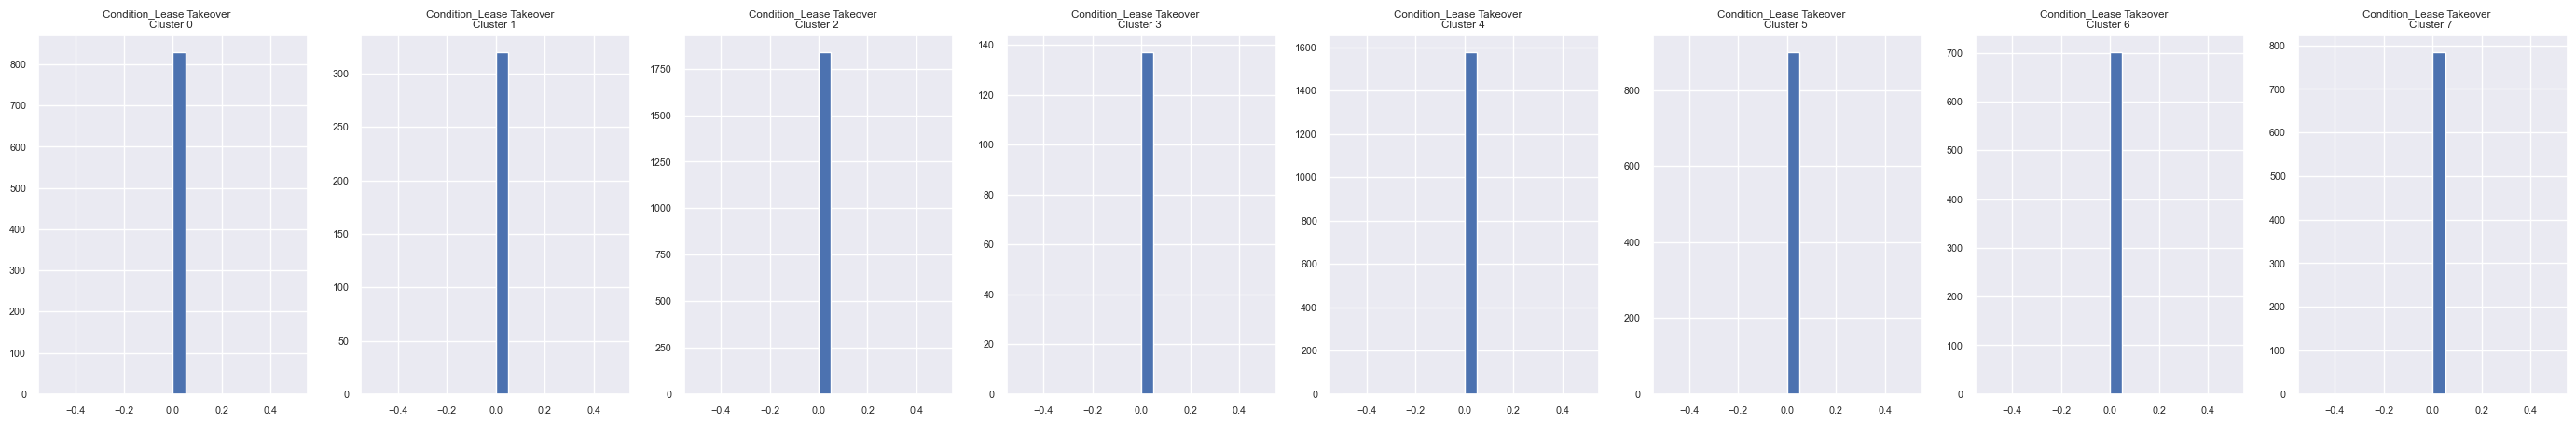

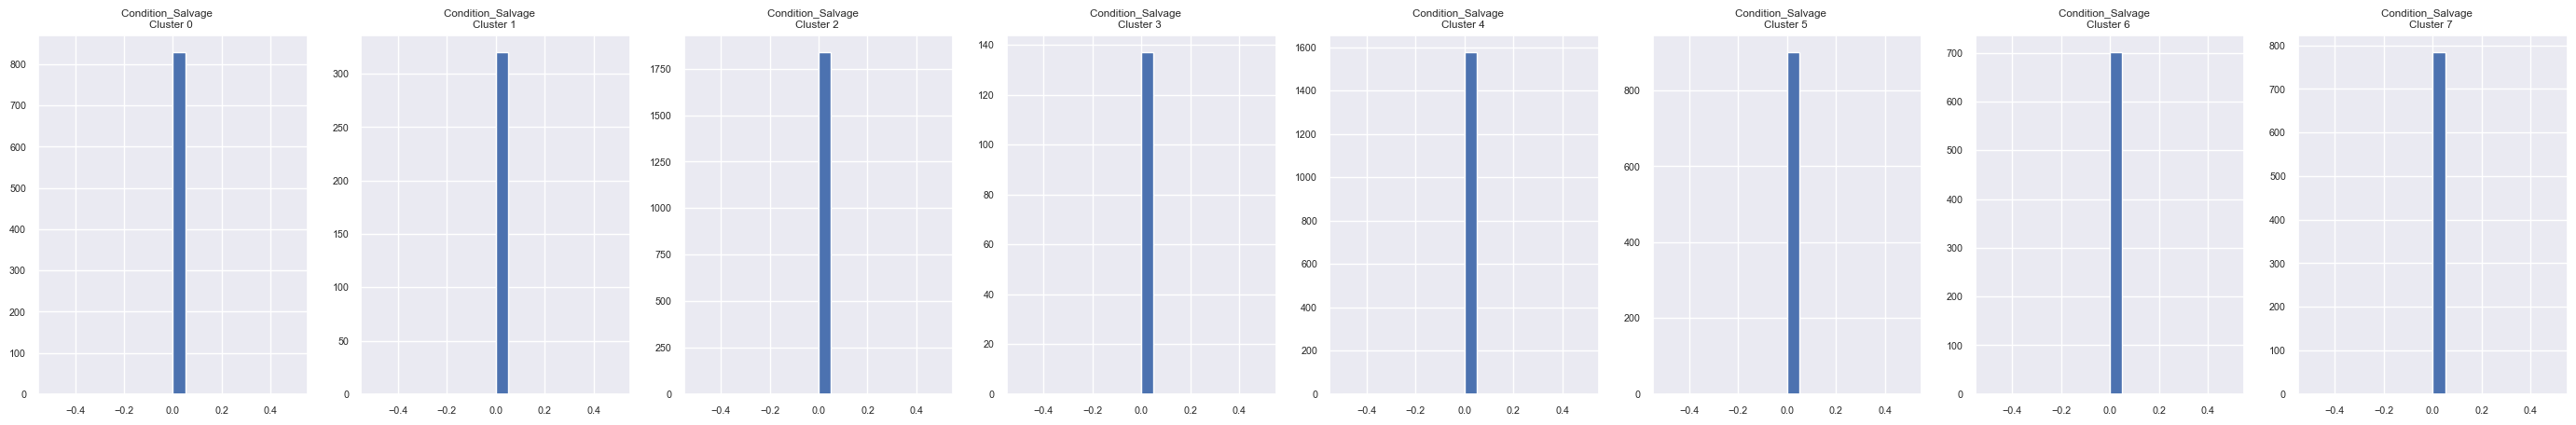

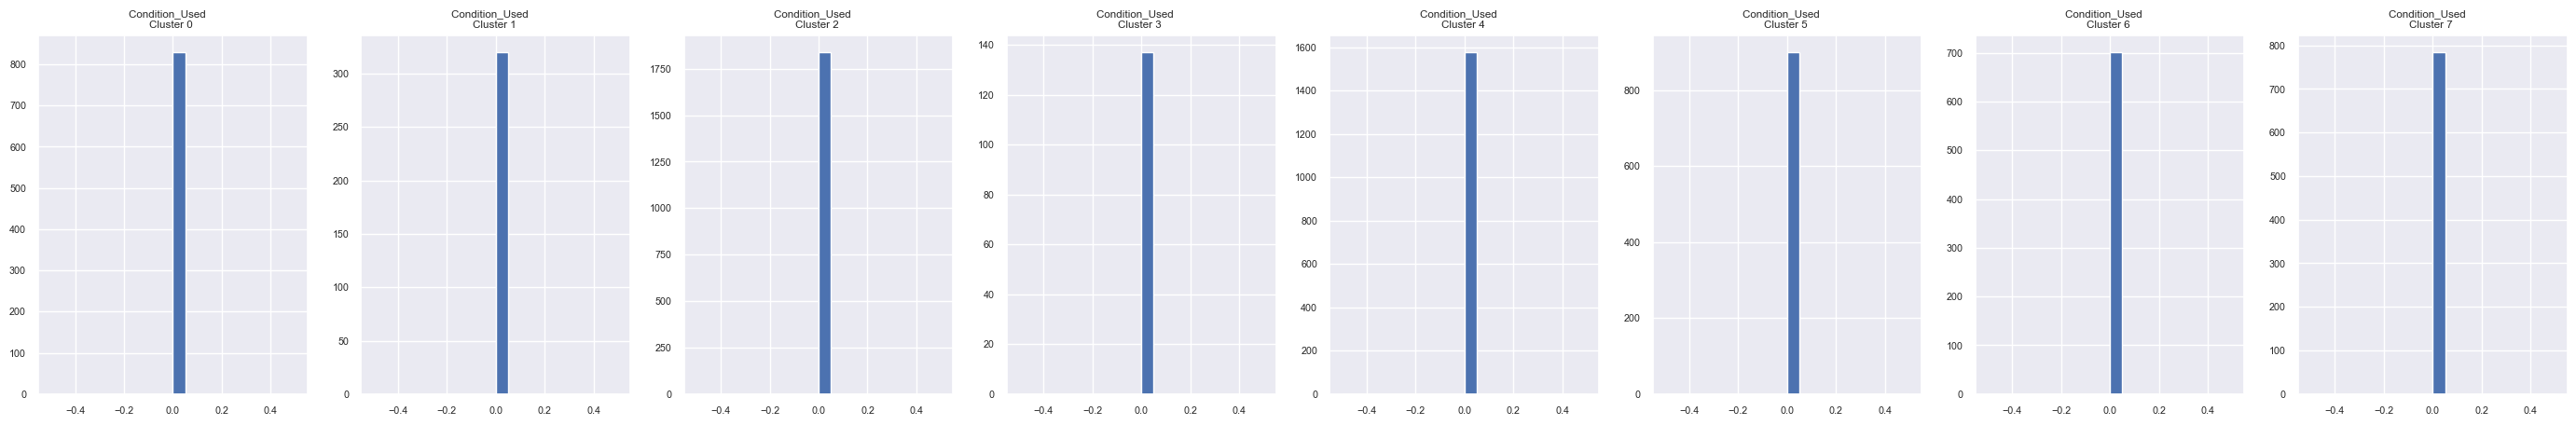

In [68]:
for i in df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(8):
    plt.subplot(1,8,j+1)
    cluster = df_cluster[df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))

  plt.show()

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_imputed)
principal_comp

array([[3.25419912e+00, 1.05000141e+00],
       [1.80077827e+00, 1.76556844e+00],
       [3.71810463e+00, 1.37751589e+00],
       ...,
       [9.49942202e-18, 7.98098917e-18],
       [9.49942202e-18, 7.98098917e-18],
       [9.49942202e-18, 7.98098917e-18]])

In [70]:
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,3.254199,1.050001
1,1.800778,1.765568
2,3.718105,1.377516
3,1.742275,2.462661
4,3.778443,1.420114


In [71]:
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,3.254199,1.050001,0
1,1.800778,1.765568,6
2,3.718105,1.377516,0
3,1.742275,2.462661,3
4,3.778443,1.420114,0


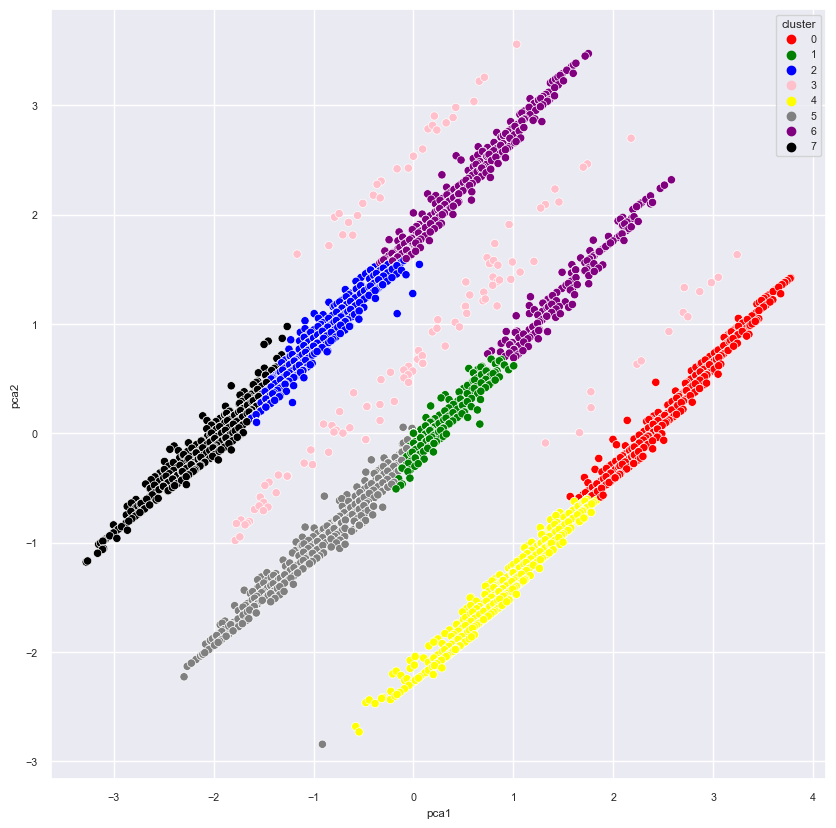

In [72]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','pink','yellow','gray','purple', 'black'])
plt.show()

In [73]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD

encoding_dim = 8

input_df = Input(shape=(15,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(x)

x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(15, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [74]:
df_imputed.shape

(11873, 15)

In [75]:
autoencoder.fit(df_imputed,df_imputed, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25
93/93 [==============================] - 5s 33ms/step - loss: 0.0499
Epoch 2/25
93/93 [==============================] - 3s 34ms/step - loss: 0.0043
Epoch 3/25
93/93 [==============================] - 3s 33ms/step - loss: 0.0044
Epoch 4/25
93/93 [==============================] - 3s 34ms/step - loss: 0.0019
Epoch 5/25
93/93 [==============================] - 3s 34ms/step - loss: 0.0012
Epoch 6/25
93/93 [==============================] - 3s 34ms/step - loss: 6.7237e-04
Epoch 7/25
93/93 [==============================] - 3s 34ms/step - loss: 5.2818e-04
Epoch 8/25
93/93 [==============================] - 3s 34ms/step - loss: 7.9195e-04
Epoch 9/25
93/93 [==============================] - 3s 34ms/step - loss: 6.2341e-04
Epoch 10/25
93/93 [==============================] - 3s 33ms/step - loss: 0.0026
Epoch 11/25
93/93 [==============================] - 3s 35ms/step - loss: 5.6311e-04
Epoch 12/25
93/93 [==============================] - 3s 34ms/step - loss: 6.6350e-04
Epoch 13/25
9

In [76]:
pred = encoder.predict(df_imputed)

372/372 [==============================] - 2s 4ms/step


In [77]:
pred.shape

(11873, 10)

C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\skl

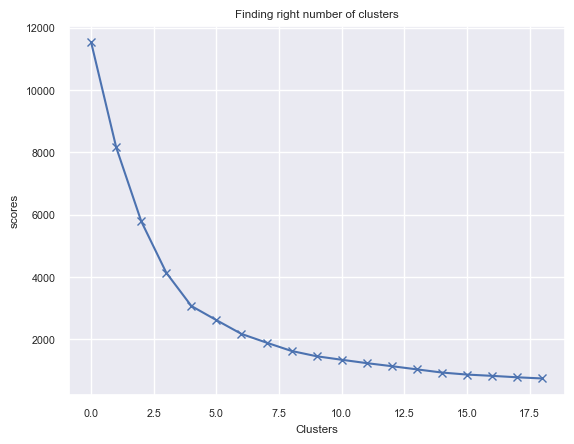

In [78]:
scores_2 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(pred)
  scores_2.append(kmeans.inertia_)

plt.plot(scores_2, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\3067751309.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores_1, 'bx-', color = 'r')
C:\Users\Dell\AppData\Local\Temp\ipykernel_14252\3067751309.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores_2, 'bx-', color = 'g')


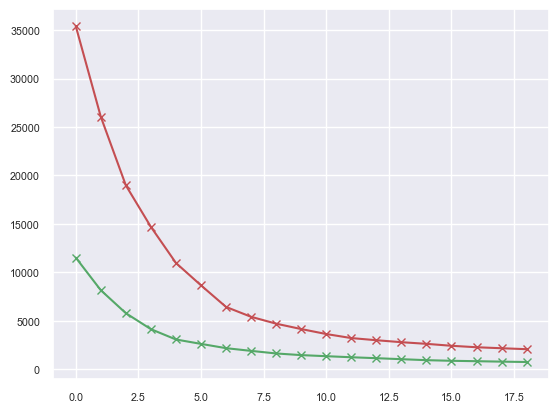

In [79]:
plt.plot(scores_1, 'bx-', color = 'r')
plt.plot(scores_2, 'bx-', color = 'g')

In [80]:
kmeans = KMeans(4)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(df_imputed)

C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [81]:
from sklearn.metrics import silhouette_score
print(silhouette_score(pred, labels))

0.5308561


In [82]:
df_cluster_dr = pd.concat([df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,Price,Year:,Fuel Type:_Electric,Fuel Type:_Gasoline,Fuel Type:_Hybrid-Electric,Fuel Type:_Other,Transmission:_Manual,Transmission:_Other,Drivetrain:_All-wheel drive (AWD),Drivetrain:_Front-wheel drive (FWD),Drivetrain:_Other,Drivetrain:_Rear-wheel drive (RWD),Condition_Lease Takeover,Condition_Salvage,Condition_Used,cluster
0,-1.396973,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,2.0
1,-0.786657,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0,2.0
2,-2.226696,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,2.0
3,-0.566836,-2.904325,0.0,-7.121982,0.0,0.0,0.0,0.0,-0.898695,-0.720396,0.0,0.0,0.0,0.0,0.0,1.0
4,-2.334614,-2.904325,0.0,0.140410,0.0,0.0,0.0,0.0,-0.898695,1.388125,0.0,0.0,0.0,0.0,0.0,2.0


In [83]:
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,1.931949,0.041670
1,0.836720,0.033917
2,2.168317,0.206733
3,4.512332,1.436834
4,2.198126,0.221247


In [84]:
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,1.931949,0.041670,2
1,0.836720,0.033917,2
2,2.168317,0.206733,2
3,4.512332,1.436834,1
4,2.198126,0.221247,2


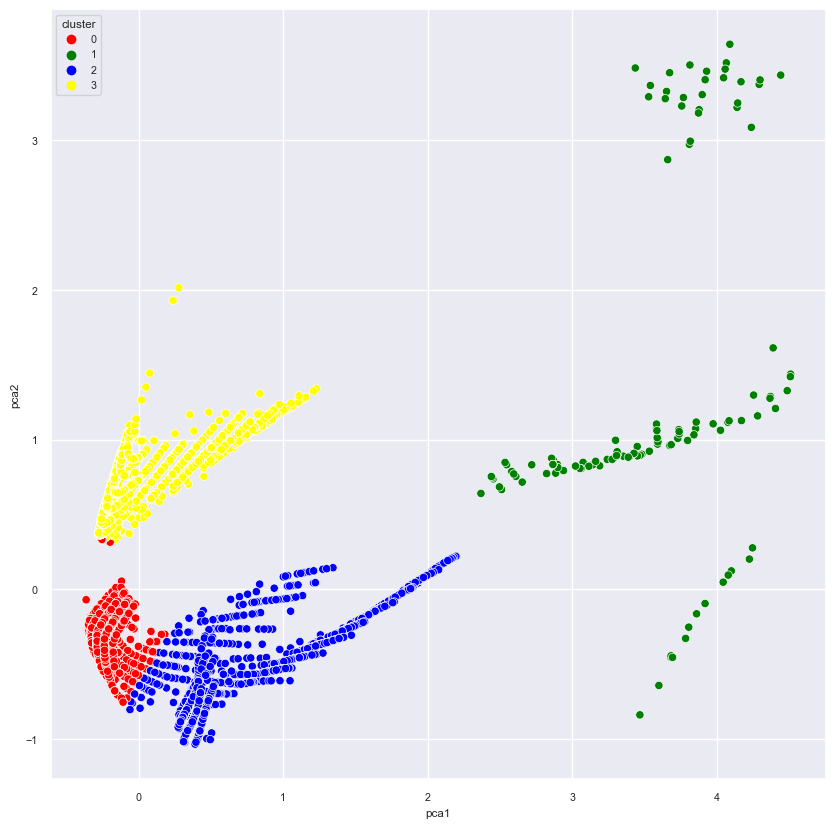

In [85]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','yellow'])
plt.show()